# EDSA CPT Group 12 Linear Regression
## kaggle House Prices: Advanced Regression Techniques

----
**Team Members**: Simphiwe Dangazela | Lakhiwe Liwani | Zipho Matiso | Purity Molala | Niel Smith

----
# Introduction

The goals of this notebook is to analyse the data provided in order to accurately fit applicable machine learning models that can be used to predict the price of a house based on certain features.

----
# Load libraries and modules

In [6]:
%matplotlib inline

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy import stats

from scipy.special import boxcox1p

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-paper')

----
# Load the data sets

The first step is to load the data sets provided by the competition into dataframes. This includes a training set that will be used to train and validate the models. A test set is provided that must be used to make predictions to be submitted for a score.

In [8]:
# # Run this cell for local machine.
# df_train = pd.read_csv('train.csv', index_col='Id')
# df_test = pd.read_csv('test.csv', index_col='Id')
# sample_sub = pd.read_csv('sample_submission.csv', index_col='Id')

In [19]:
# Run this cell for kaggle kernel.
import os
# print(os.listdir("../input"))

df_train = pd.read_csv('train.csv', index_col='Id')
df_test = pd.read_csv('test.csv', index_col='Id')
sample_sub = pd.read_csv('sample_submission.csv', index_col='Id')

In [20]:
# Do not truncate columns and rows of displayed dataframes.
pd.options.display.max_columns = None
# pd.options.display.max_rows = None

In [21]:
# The saleprice of every house is to be predicted and assign as the target.
target = df_train[['SalePrice']]

In [22]:
# Test and train data sets are joined along the index.
data = pd.concat([df_train, df_test], sort=False)

----
# EDA
The Exploratory Data Analysis helps to understand what data cleaning and transformation steps are required. This helps to decided on what machine learning models can be considered.

----
## The data

In [23]:
# Find the number of rows and columns.
pd.DataFrame([[df_train.shape[0], df_train.shape[1]],
              [df_test.shape[0], df_test.shape[1]] ],
             index=['Train Set', 'Test Set'],
             columns=['Number of rows', 'Number of columns'])

,Number of rows,Number of columns
Train Set,1460,80
Test Set,1459,79


In [24]:
# List all the columns (features).
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [25]:
# Find columns that are only in training set and not in the test set (submission set).
[col for col in df_train.columns if col not in df_test.columns]

['SalePrice']

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-null object
Exterior2nd      2918 non

In [27]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [28]:
# List the columns with numerical types.
numerical = data.dtypes[data.dtypes != object].index.tolist()
pd.DataFrame(numerical, index=range(1, len(numerical)+1), columns=['Numerical'])

,Numerical
1,MSSubClass
2,LotFrontage
3,LotArea
4,OverallQual
5,OverallCond
6,YearBuilt
7,YearRemodAdd
8,MasVnrArea
9,BsmtFinSF1
10,BsmtFinSF2


In [29]:
# List the columns with non-numerical types.
categorical = data.dtypes[data.dtypes == object].index.tolist()
pd.DataFrame(categorical, index=range(1, len(categorical)+1), columns=['Categorical'])

,Categorical
1,MSZoning
2,Street
3,Alley
4,LotShape
5,LandContour
6,Utilities
7,LotConfig
8,LandSlope
9,Neighborhood
10,Condition1


There are a number of columns that are missing values. The columns are also of different datatypes (object, int, float) that will have to be inspected to be used as numerical or categorical features. Some of the columns might need to be changed from numerical to categorical and vice versa.

In [30]:
data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


----
## The target: Sale Price

The house feature that must be predicted is its house price and will therefore be referred to as the target variable.
An inspection of the sale prices is done.

Only the test set contains sale price observations as the sale price must be predicted for the test set.

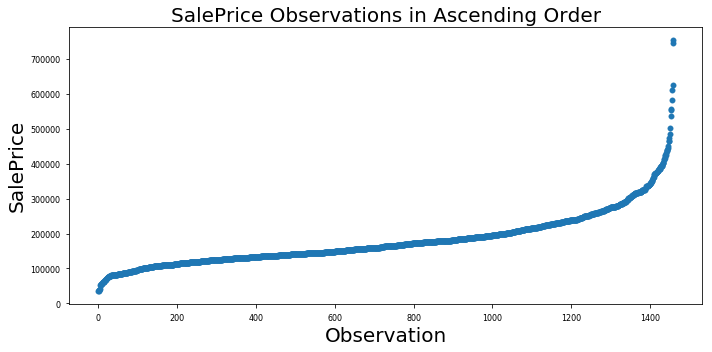

In [31]:
# Plot the SalePrice observations in ascending order.
plt.figure(figsize=(10,5))
plt.scatter(range(len(target)), target.sort_values(by='SalePrice'))
plt.xlabel('Observation',fontsize=20)
plt.ylabel('SalePrice',fontsize=20)
plt.title('SalePrice Observations in Ascending Order',fontsize=20)

plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.tight_layout()
# plt.savefig("saleprice_ordered.jpeg", dpi=150)

The training set has entries with very high house prices that will cause a skew distrubtion of data.

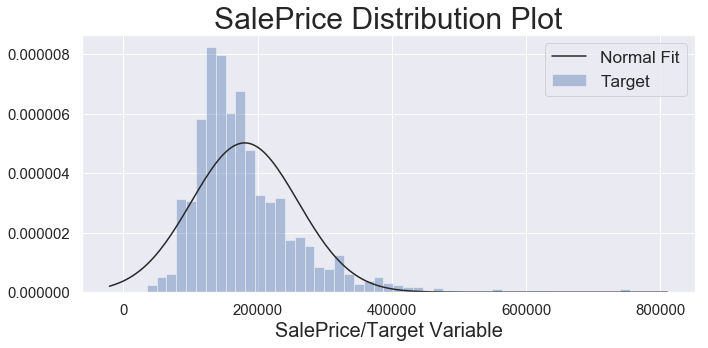

In [32]:
# Plot the distribution of the SalePrice observations and compare to a normal distribution.
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.distplot(target, fit=stats.norm, kde=False, hist_kws={"label": "Target"}, fit_kws={"label": "Normal Fit"})
ax.axes.set_title("SalePrice Distribution Plot",fontsize=30)
ax.set_xlabel("SalePrice/Target Variable",fontsize=20)
ax.tick_params(labelsize=15)
ax.legend(fontsize='x-large', title_fontsize='40')
plt.tight_layout()
# plt.savefig("sales_dist_skew.jpeg", dpi=150)

The SalePrice values are not normally distributed, but rather skewed to the right/positively skewed (Skewness value > 0).
This means that the very expensive houses are seen as outliers. The following boxplot and descriptive statistics confirms the skewness.

In [33]:
# Calculate the skewness.
stats.skew(target)

array([1.88094075])

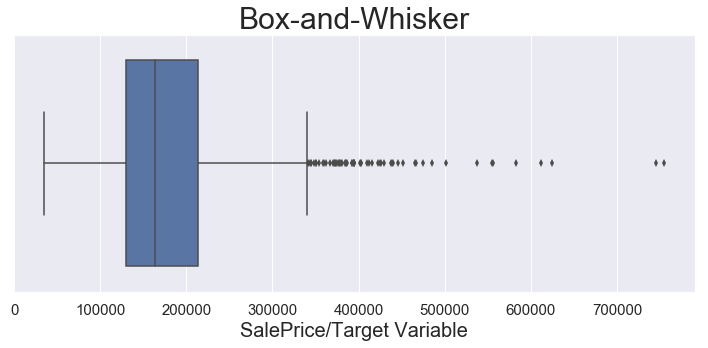

In [34]:
# Plot a boxplot for Saleprice.
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.boxplot(x = target)
ax.axes.set_title("Box-and-Whisker",fontsize=30)
ax.set_xlabel("SalePrice/Target Variable",fontsize=20)
ax.tick_params(labelsize=15)
plt.tight_layout()
# plt.savefig("skew_box.jpeg", dpi=150)

In [35]:
target.describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


The sale price data will be log transformed.

In [36]:
target_log1p = np.log1p(target)

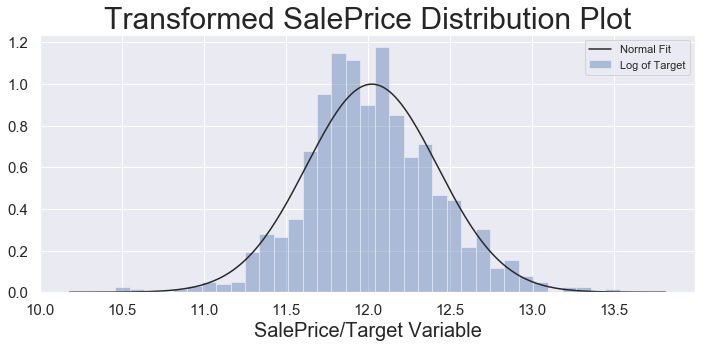

In [37]:
# Plot the log transformed distribution of the SalePrice observations and compare to a normal distribution.
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.distplot(target_log1p, fit=stats.norm, kde=False, hist_kws={"label": "Log of Target"}, fit_kws={"label": "Normal Fit"})
ax.axes.set_title("Transformed SalePrice Distribution Plot",fontsize=30)
ax.set_xlabel("SalePrice/Target Variable",fontsize=20)
ax.legend()
ax.tick_params(labelsize=15)
plt.tight_layout()
# plt.savefig("saleprice_dist_correct.jpeg", dpi=150)

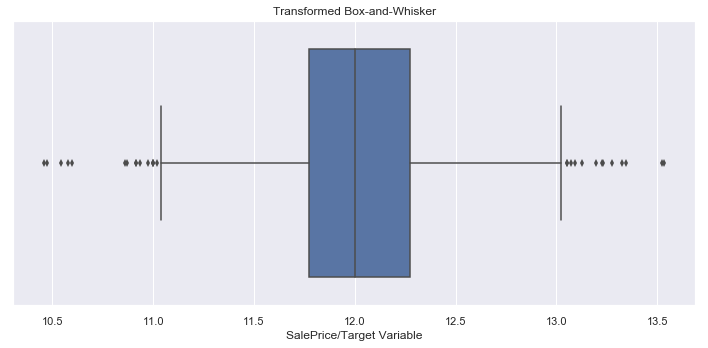

In [38]:
# Plot the transformed saleprice boxplot.
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.boxplot(x = target_log1p)
ax.set(xlabel='SalePrice/Target Variable',title='Transformed Box-and-Whisker')
plt.tight_layout()
# plt.savefig("norm_box.jpeg", dpi=150)

In [39]:
stats.skew(target_log1p)

array([0.12122191])

----
## Correlations

A correlation matrix is created and plotted as a heatmap to see which variables are correlated to the target and to each other.

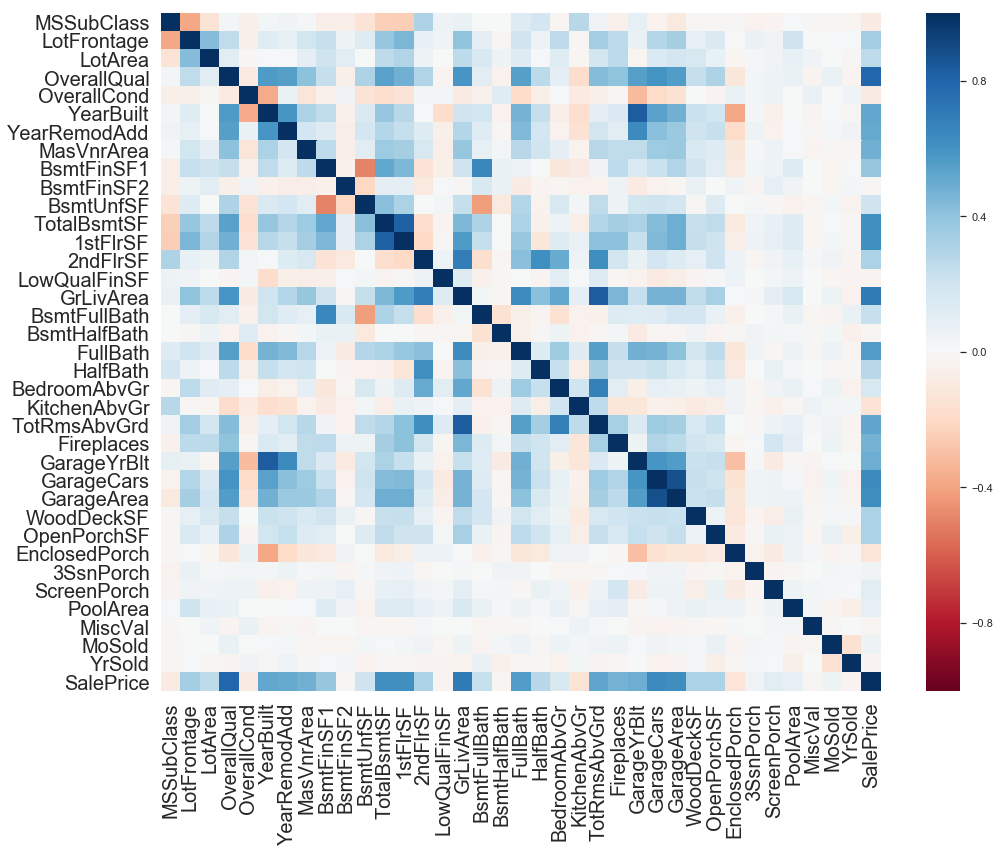

In [40]:
# Create a correlation matrix between all numerical features of the training data.
correlation_matrix = df_train.corr().round(2)
sns.set(rc={'figure.figsize':(15,12)})
ax = sns.heatmap(data=correlation_matrix, vmin=-1, vmax=1, cmap='RdBu')
ax.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig("heatmap.jpeg", dpi=150)

At this stage only numerical features can be seen. When the categorical features are transformed into numerical features the correlations can be checked again.

The correlation heatmap shows that OverallQual and GrLivArea are two of the strongest predictors for the sale price. Multicollinearity  between predictors can also be observed. YearBuilt and GarageYBlt are strongly correlated as can be expected, since a house and its garage are built around the same year.

In [26]:
strongest = abs(correlation_matrix['SalePrice']).sort_values(ascending=False)[:11].index
strong_matrix = correlation_matrix.loc[strongest,strongest]
strong_matrix

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
SalePrice,1.00,0.79,0.71,0.64,0.62,0.61,0.61,0.56,0.53,0.52,0.51
OverallQual,0.79,1.00,0.59,0.60,0.56,0.54,0.48,0.55,0.43,0.57,0.55
GrLivArea,0.71,0.59,1.00,0.47,0.47,0.45,0.57,0.63,0.83,0.20,0.29
GarageCars,0.64,0.60,0.47,1.00,0.88,0.43,0.44,0.47,0.36,0.54,0.42
GarageArea,0.62,0.56,0.47,0.88,1.00,0.49,0.49,0.41,0.34,0.48,0.37
TotalBsmtSF,0.61,0.54,0.45,0.43,0.49,1.00,0.82,0.32,0.29,0.39,0.29
1stFlrSF,0.61,0.48,0.57,0.44,0.49,0.82,1.00,0.38,0.41,0.28,0.24
FullBath,0.56,0.55,0.63,0.47,0.41,0.32,0.38,1.00,0.55,0.47,0.44
TotRmsAbvGrd,0.53,0.43,0.83,0.36,0.34,0.29,0.41,0.55,1.00,0.10,0.19
YearBuilt,0.52,0.57,0.20,0.54,0.48,0.39,0.28,0.47,0.10,1.00,0.59


If the features strongest correlated to SalePrice is plotted, the variation in the relationships can be seen.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


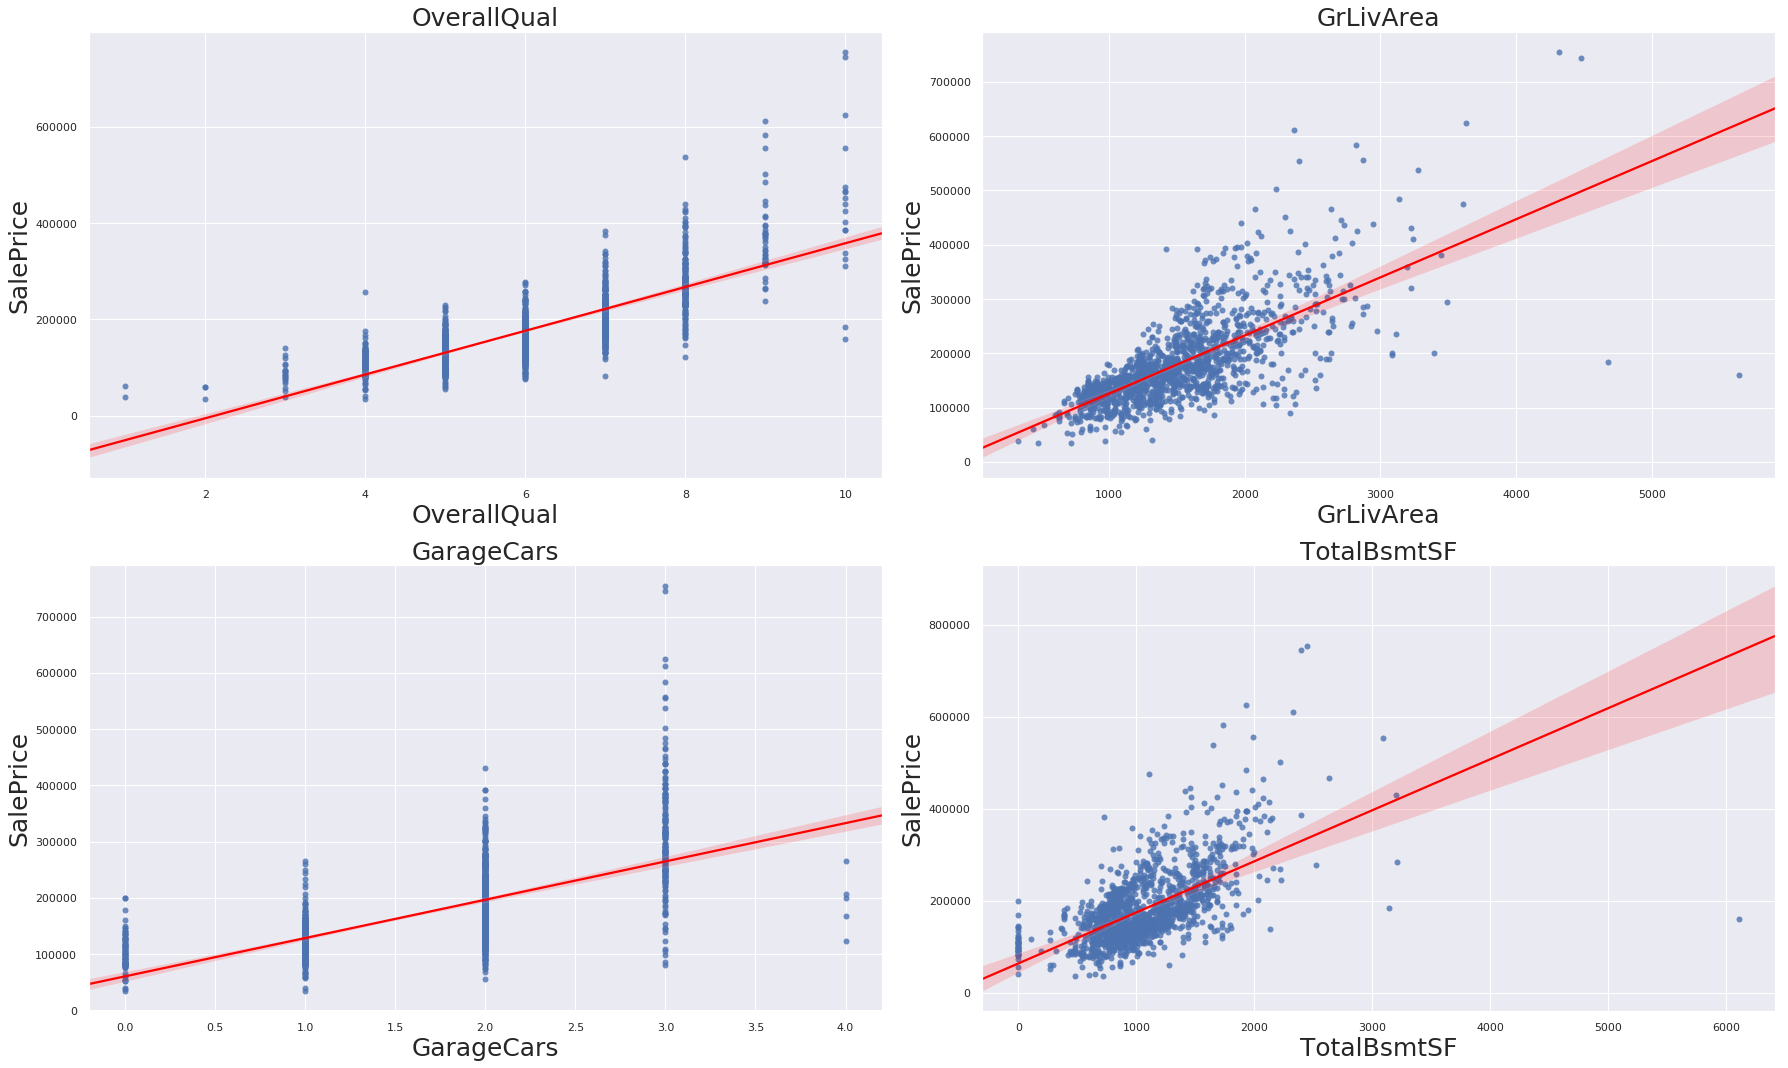

In [27]:
# Plot scatters of strongest numerical features vs SalePrice.
plt.figure(figsize=(25, 15))
strong_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']

for i, col in enumerate(strong_features):
    plt.subplot(2, len(strong_features)/2 , i+1)
    sns.regplot(df_train[col], df_train['SalePrice'], line_kws={"color": "red"})
    plt.title(col, fontsize=25)
    plt.xlabel(col, fontsize=25)
    plt.ylabel('SalePrice', fontsize=25)
plt.tight_layout()
# plt.savefig("strong_correlations.jpeg", dpi=150)

All three features have nearly linear relationships with the target variable - SalePrice.
The residual variation in OverallQual looks to be constant where in general living area it fans out at higher prices and areas.

In [28]:
df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


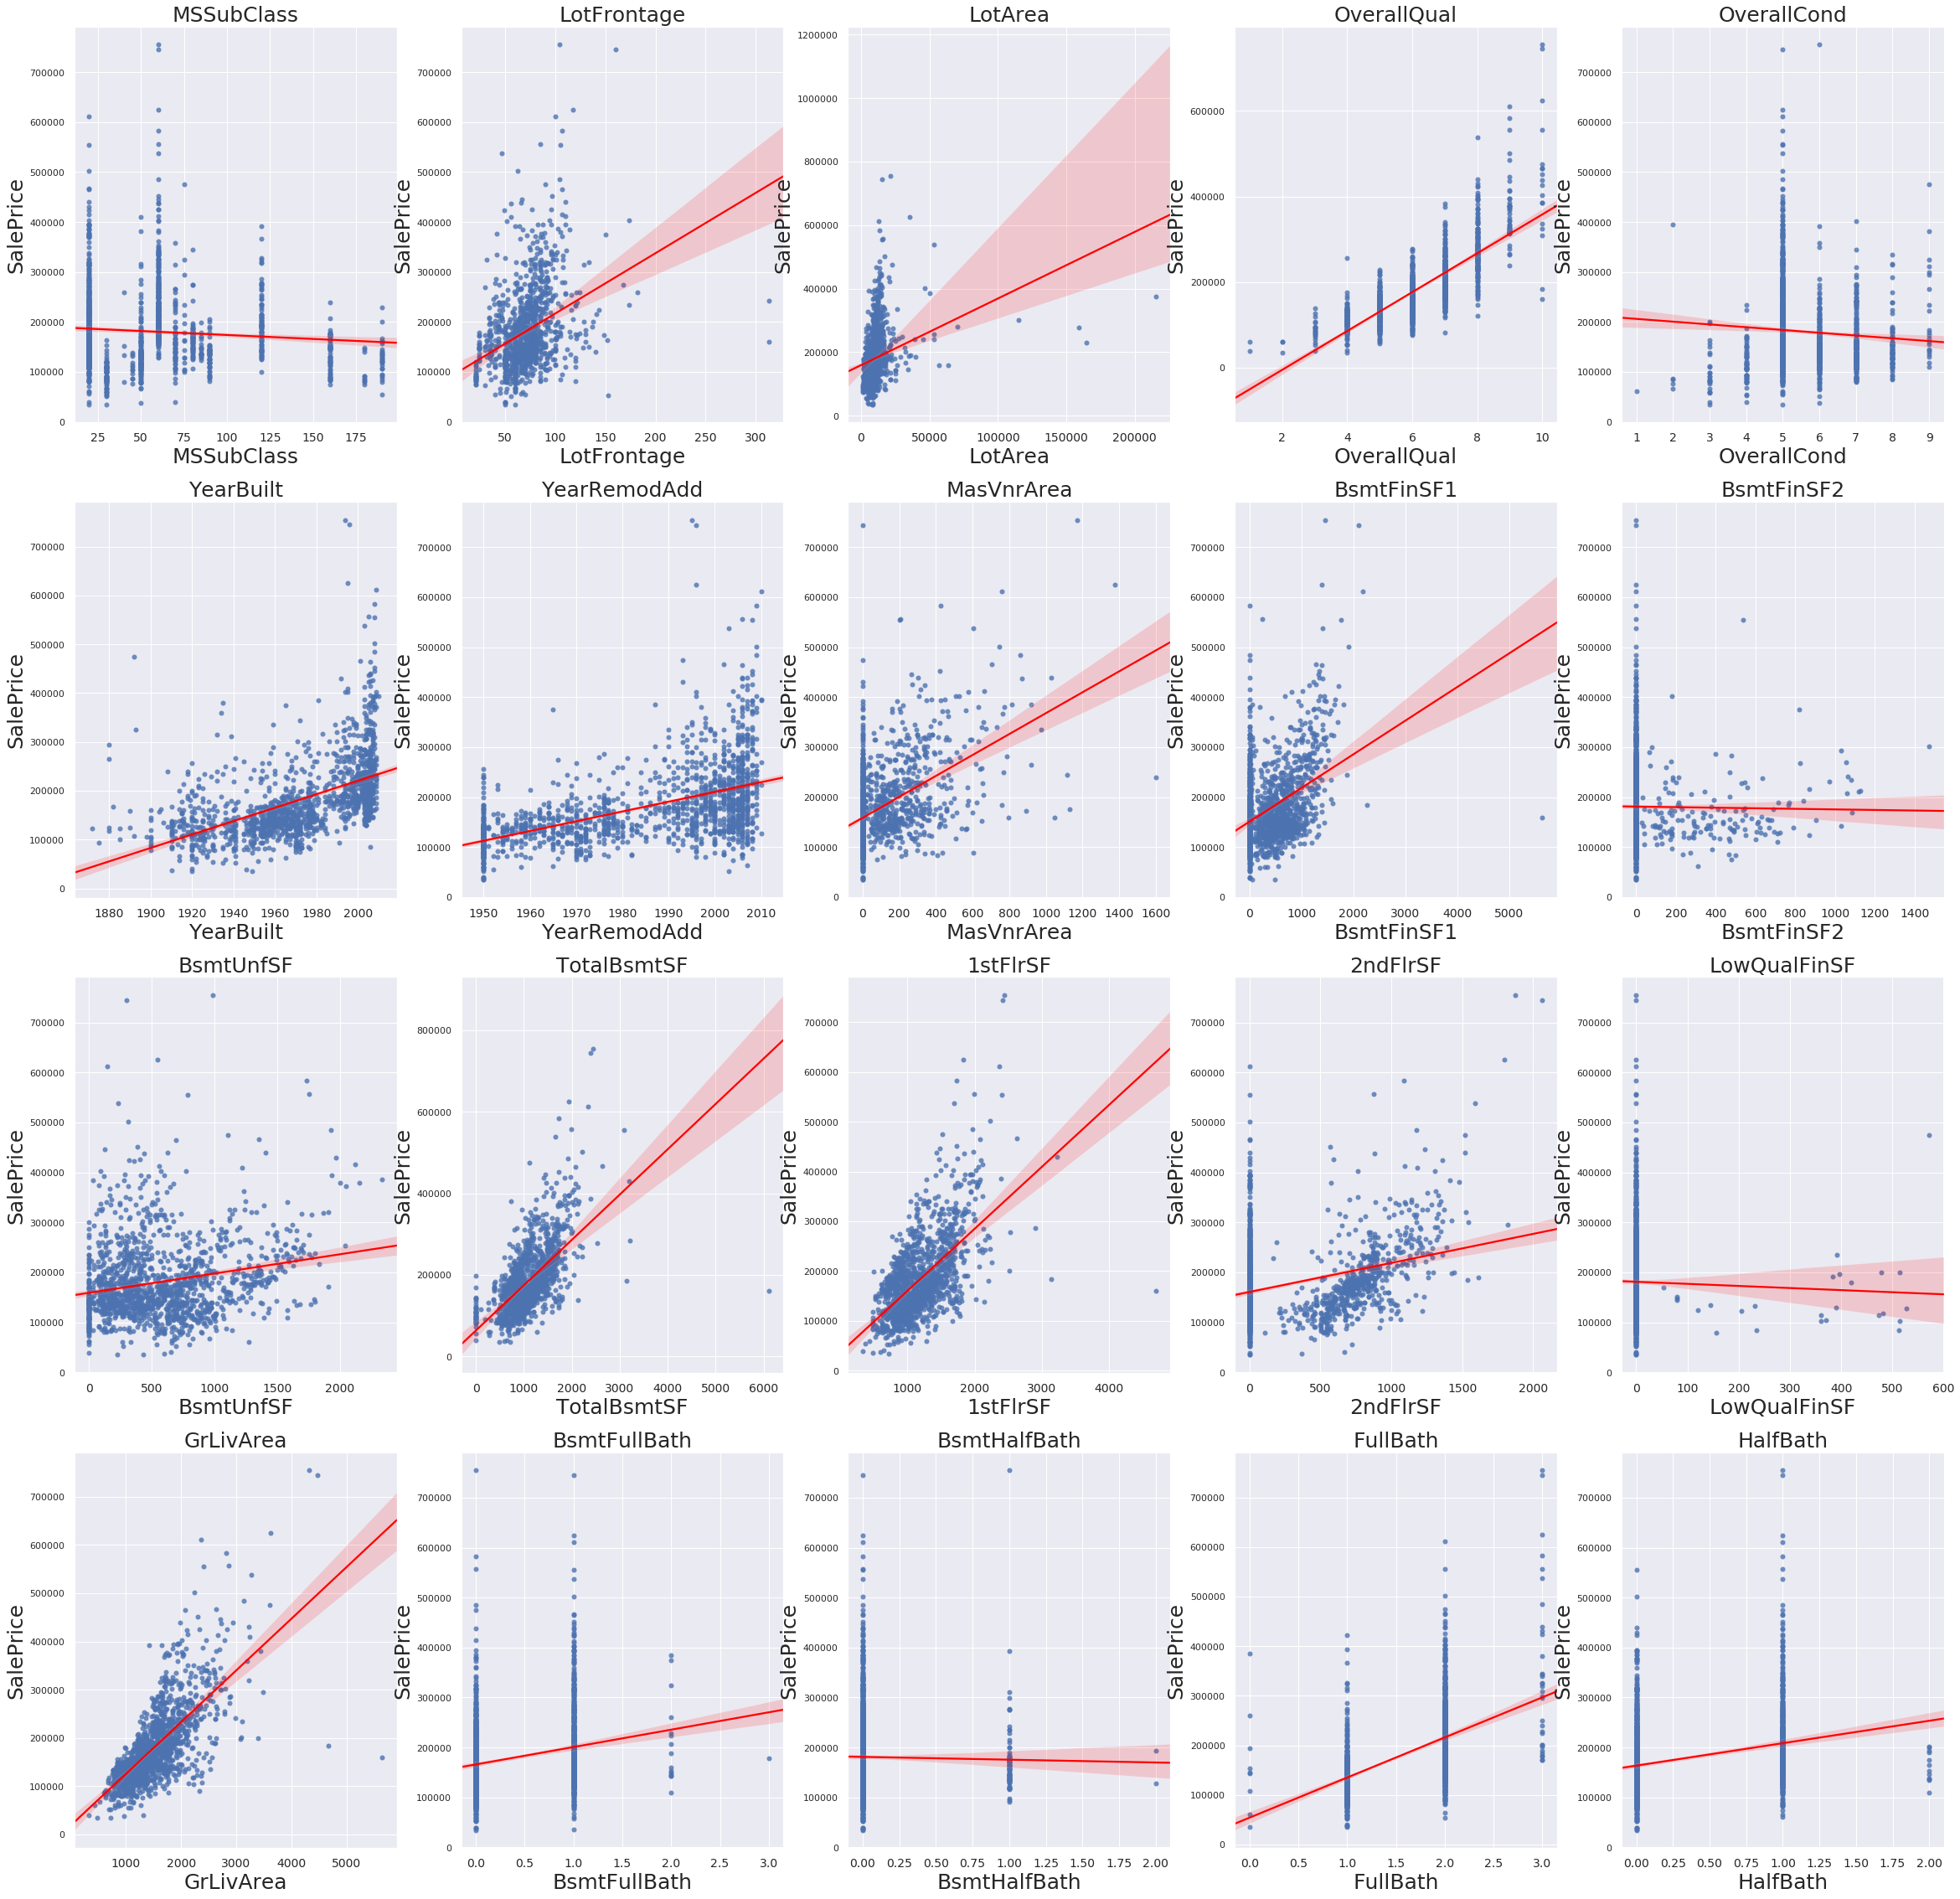

In [29]:
# Plot linear regression fit scatter plots for first 20 numerical.
plt.figure(figsize=(40,40))
i = 1
for col in numerical[:20]:
    plt.subplot(4,5,i)
    sns.regplot(df_train[col], df_train['SalePrice'], line_kws={"color": "red"})
    plt.title(col, fontsize=25)
    plt.xlabel(col, fontsize=25)
    plt.ylabel('SalePrice', fontsize=25)
    plt.xticks(fontsize=14)
    plt.xticks(fontsize=14)
    i = i + 1

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


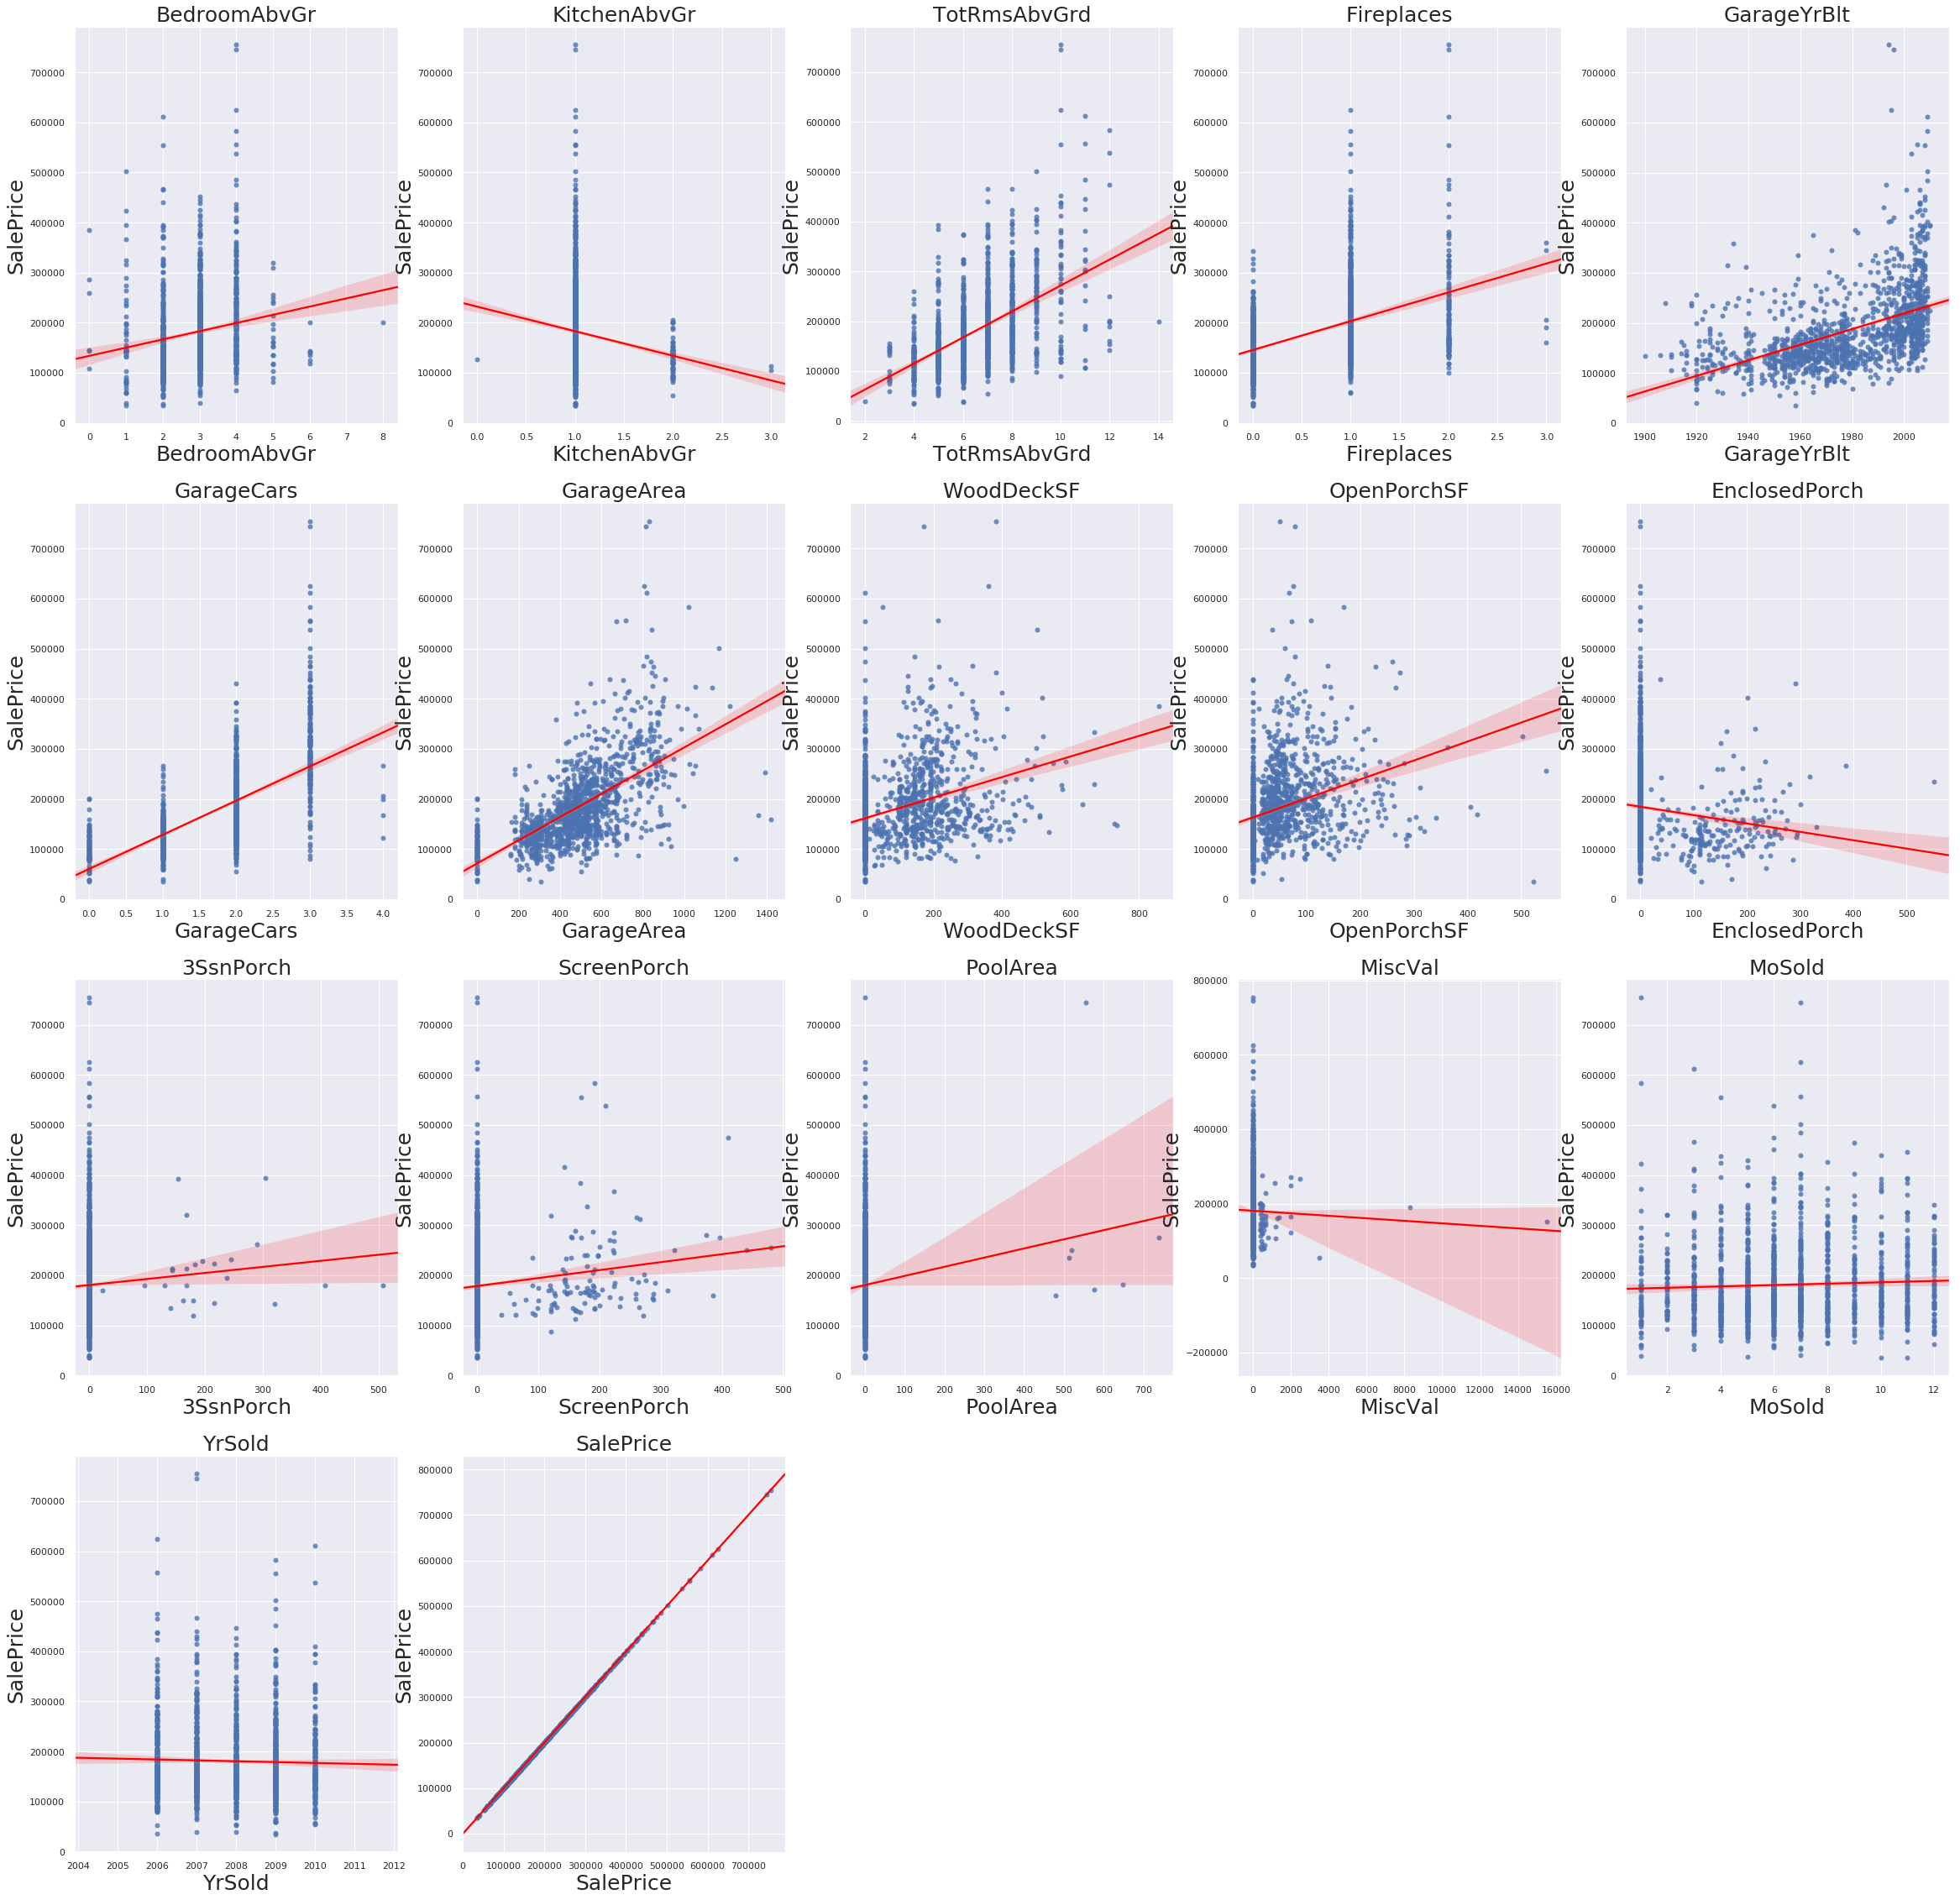

In [30]:
# Plot linear regression fit scatter plots for the rest of numerical.
plt.figure(figsize=(40,40))
i = 1
for col in numerical[20:]:
    plt.subplot(4,5,i)
    sns.regplot(df_train[col], df_train['SalePrice'], line_kws={"color": "red"})
    plt.title(col, fontsize=25)
    plt.xlabel(col, fontsize=25)
    plt.ylabel('SalePrice', fontsize=25)
    i = i + 1

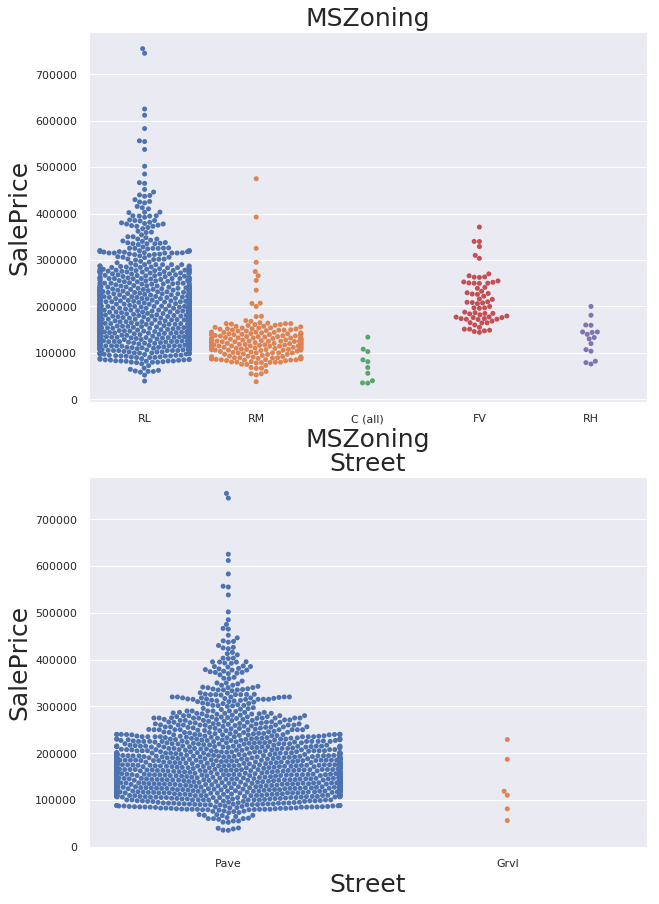

In [31]:
# Plot swarmplots of first 2 categorical features.
# It is too slow to plot all.
plt.figure(figsize=(10,15))
i = 1
for col in categorical[:2]:
    plt.subplot(2,1,i)
    sns.swarmplot(df_train[col], df_train['SalePrice'])
    plt.title(col, fontsize=25)
    plt.xlabel(col, fontsize=25)
    plt.ylabel('SalePrice', fontsize=25)
    i = i + 1

----
# Filling in missing values

In [32]:
# Create a dataframe showing missing values for train, test and combined.
missing_values = pd.concat([df_train.isna().sum(), df_test.isna().sum()], axis=1, keys=['Train', 'Test'], sort=False)
missing_values['Combined Data'] = missing_values.sum(axis=1)
missing_values['Percentage Missing'] = missing_values['Combined Data']/data.shape[0]*100
missing_values = missing_values[missing_values['Combined Data']>0].sort_values(by='Combined Data', ascending=False)
missing_values

,Train,Test,Combined Data,Percentage Missing
PoolQC,1453,1456.0,2909.0,99.657417
MiscFeature,1406,1408.0,2814.0,96.402878
Alley,1369,1352.0,2721.0,93.216855
Fence,1179,1169.0,2348.0,80.438506
FireplaceQu,690,730.0,1420.0,48.646797
LotFrontage,259,227.0,486.0,16.649538
GarageFinish,81,78.0,159.0,5.447071
GarageQual,81,78.0,159.0,5.447071
GarageCond,81,78.0,159.0,5.447071
GarageYrBlt,81,78.0,159.0,5.447071


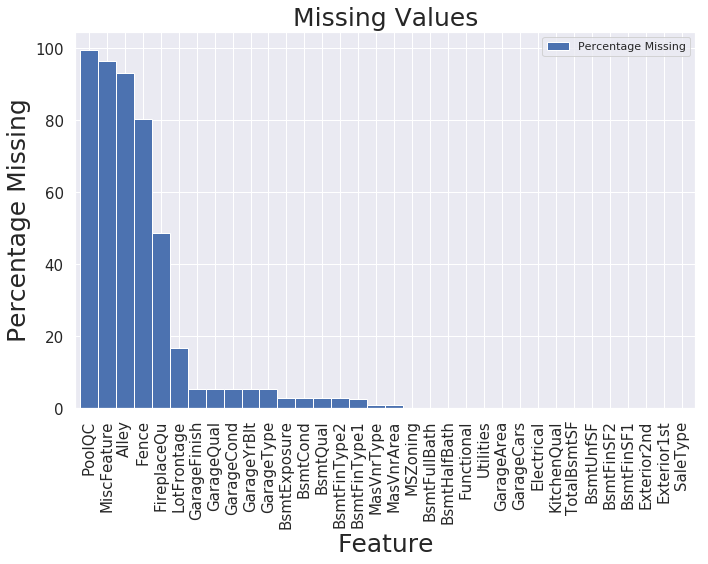

In [33]:
# Plot the missing quantities.
ax = missing_values[['Percentage Missing']].plot.bar(figsize=(10,8), width=1)
plt.ylabel('Percentage Missing', fontsize=25)
plt.xlabel('Feature', fontsize=25)
plt.title('Missing Values', fontsize=25)
ax.tick_params(labelsize=15)
plt.tight_layout()
# plt.savefig("missing data.jpeg", dpi=150)

In [34]:
# # Open, read and close the desciption text file.
# # Only use this cell locally.
# f = open('data_description.txt', 'r')
# for line in f:
#     print(line)
# f.close()

The PoolQC has the most missing values. The different values for PoolQC is inspected and also the related feaure, namely, PoolArea. The data description text file is also consulted.

In [35]:
data['PoolQC'].value_counts()

Ex    4
Gd    4
Fa    2
Name: PoolQC, dtype: int64

In [36]:
data['PoolArea'].value_counts()

0      2906
561       1
555       1
519       1
800       1
738       1
648       1
576       1
512       1
480       1
444       1
368       1
228       1
144       1
Name: PoolArea, dtype: int64

In [37]:
# Check where there is a pool but no QC value.
pools_noQC = data[(data['PoolQC'].isna()) & (data['PoolArea']!=0)][['PoolQC']].index
data.loc[pools_noQC, ['PoolQC','PoolArea','OverallQual', 'OverallCond', 'ExterQual', 'ExterCond']]

,PoolQC,PoolArea,OverallQual,OverallCond,ExterQual,ExterCond
Id,,,,,,
2421,NaN,368,4,6,TA,TA
2504,NaN,444,6,5,TA,TA
2600,NaN,561,3,5,TA,TA


The missing values for PoolQC without an actual pool can be set to 'none' while the three unknown pool qualities with PoolAreas will be assumed to be average/typical.

In [38]:
data.loc[pools_noQC, 'PoolQC'] = 'TA'

In [39]:
data['PoolQC'].fillna('none', inplace=True)

MiscFeature, Alley, and Fence are replaced with 'none' when there is no instance of the feature as per the description text.

In [40]:
data.loc[data[(data['MiscFeature'].isna()) & (data['MiscVal']!=0)].index][['MiscFeature','MiscVal']]

,MiscFeature,MiscVal
Id,,
2550,NaN,17000


In [41]:
data['MiscFeature'].value_counts()

Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64

In [42]:
data.loc[2550, 'MiscFeature'] = 'Othr'

In [43]:
data['MiscFeature'].fillna('none', inplace=True)

In [44]:
data['Alley'].fillna('none', inplace=True)

In [45]:
data['Fence'].fillna('none', inplace=True)

The missing fireplace qualities is checked for values>0.

In [46]:
data[(data['FireplaceQu'].isna()) & (data['Fireplaces']!=0)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [47]:
data[(data['FireplaceQu'].isna()) & (data['Fireplaces']==0)].index

Int64Index([   1,    6,   11,   13,   16,   18,   19,   20,   27,   30,
            ...
            2906, 2908, 2909, 2910, 2911, 2913, 2914, 2915, 2916, 2918],
           dtype='int64', name='Id', length=1420)

In [48]:
data['FireplaceQu'].fillna('none', inplace=True)

Investigating how the house prices vary per neighborhood, and looking at the diferences between the mean and median per neighborhood helps to indicate what value to use to fill the NaN for LotFrontage.

In [49]:
pd.concat([data.groupby('Neighborhood').median()['LotFrontage'],
           data.groupby('Neighborhood').mean()['LotFrontage'],
           data.groupby('Neighborhood').mean()['SalePrice']],axis=1)

,LotFrontage,LotFrontage,SalePrice
Neighborhood,,,
Blmngtn,43.0,46.900000,194870.882353
Blueste,24.0,27.300000,137500.000000
BrDale,21.0,21.500000,104493.750000
BrkSide,51.0,55.789474,124834.051724
ClearCr,80.5,88.150000,212565.428571
CollgCr,70.0,71.336364,197965.773333
Crawfor,70.0,69.951807,210624.725490
Edwards,65.0,66.910112,128219.700000
Gilbert,64.0,74.207207,192854.506329


In [50]:
data.groupby('Neighborhood')['LotFrontage'].describe()

,count,mean,std,min,25%,50%,75%,max
Neighborhood,,,,,,,,
Blmngtn,20.0,46.900000,4.919350,43.0,43.00,43.0,53.00,53.0
Blueste,10.0,27.300000,5.313505,24.0,24.00,24.0,32.25,35.0
BrDale,30.0,21.500000,1.137147,21.0,21.00,21.0,21.00,24.0
BrkSide,95.0,55.789474,12.722818,50.0,50.00,51.0,58.50,144.0
ClearCr,20.0,88.150000,22.628057,62.0,78.00,80.5,93.25,155.0
CollgCr,220.0,71.336364,15.940401,36.0,64.00,70.0,78.00,133.0
Crawfor,83.0,69.951807,19.141262,40.0,54.00,70.0,80.00,130.0
Edwards,178.0,66.910112,26.372019,24.0,58.25,65.0,74.00,313.0
Gilbert,111.0,74.207207,28.386654,41.0,59.00,64.0,75.00,195.0


The LotFrontage is taken as the median value.

In [51]:
data['LotFrontage'].mean(), data['LotFrontage'].median()

(69.30579531442663, 68.0)

In [52]:
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

For missing basement values it is first checked if there is a basement or not.

In [53]:
# Inspect basement related values.
data[data['BsmtFinSF1'].isna()][['BsmtQual',
                                 'BsmtCond',
                                 'BsmtExposure',
                                 'BsmtFinType1',
                                 'BsmtFinType2',
                                 'BsmtFinSF1',
                                 'BsmtFinSF2',
                                 'BsmtUnfSF',
                                 'TotalBsmtSF',
                                 'BsmtHalfBath',
                                 'BsmtFullBath']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtHalfBath,BsmtFullBath
Id,,,,,,,,,,,
2121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


By inspecting the different values in the basement features it can be seen where 'No' or 'none' is applicable.

In [54]:
data['BsmtQual'].value_counts()

TA    1283
Gd    1209
Ex     258
Fa      88
Name: BsmtQual, dtype: int64

In [55]:
data['BsmtCond'].value_counts()

TA    2606
Gd     122
Fa     104
Po       5
Name: BsmtCond, dtype: int64

In [56]:
data['BsmtExposure'].value_counts()

No    1904
Av     418
Gd     276
Mn     239
Name: BsmtExposure, dtype: int64

In [57]:
data['BsmtFinType1'].value_counts()

Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64

In [58]:
data['BsmtFinType2'].value_counts()

Unf    2493
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64

The string 'none' will be used when the feautre is not there. In the case of BsmtExposure the term 'No' is used to give meaning when there is a basement but no exposure.

In [59]:
data.loc[2121, ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = 'none'
data.loc[2121, ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtHalfBath','BsmtFullBath']] = 0

In [60]:
data[data['BsmtHalfBath'].isna()][['BsmtQual',
                                   'BsmtCond',
                                   'BsmtExposure',
                                   'BsmtFinType1',
                                   'BsmtFinType2',
                                   'BsmtFinSF1',
                                   'BsmtFinSF2',
                                   'BsmtUnfSF',
                                   'TotalBsmtSF',
                                   'BsmtHalfBath',
                                   'BsmtFullBath']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtHalfBath,BsmtFullBath
Id,,,,,,,,,,,
2189,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN


In [61]:
data.loc[2189, ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = 'none'
data.loc[2189, ['BsmtHalfBath','BsmtFullBath']] = 0

In [62]:
data[( data['BsmtFinType2'].isna() ) & ( ~( data['BsmtFinType1'].isna() ) )]\
    [['BsmtQual',
      'BsmtCond',
      'BsmtExposure',
      'BsmtFinType1',
      'BsmtFinType2',
      'BsmtFinSF1',
      'BsmtFinSF2',
      'BsmtUnfSF',
      'TotalBsmtSF',
      'BsmtHalfBath',
      'BsmtFullBath']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtHalfBath,BsmtFullBath
Id,,,,,,,,,,,
333,Gd,TA,No,GLQ,NaN,1124.0,479.0,1603.0,3206.0,0.0,1.0


In this case there is a basement so a mode value is more applicable.

In [63]:
data['BsmtFinType2'].value_counts()

Unf     2493
Rec      105
LwQ       87
BLQ       68
ALQ       52
GLQ       34
none       2
Name: BsmtFinType2, dtype: int64

In [64]:
data.loc[333, ['BsmtFinType2']] = 'Unf'

In [65]:
data[( data['BsmtFinType2'].isna() ) & ( ( data['BsmtFinType1'].isna() ) )][['BsmtQual',
                                   'BsmtCond',
                                   'BsmtExposure',
                                   'BsmtFinType1',
                                   'BsmtFinType2',
                                   'BsmtFinSF1',
                                   'BsmtFinSF2',
                                   'BsmtUnfSF',
                                   'TotalBsmtSF',
                                   'BsmtHalfBath',
                                   'BsmtFullBath']].describe()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtHalfBath,BsmtFullBath
count,77.0,77.0,77.0,77.0,77.0,77.0
mean,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# Find missing exposure values with actual basements.
miss_no_BSMTexp = data[( ~( data['BsmtFinType2'].isna() ) & ~( data['BsmtFinType1'].isna() ) ) &\
                       ( data['BsmtExposure'].isna() )]\
                       [['BsmtQual',
                       'BsmtCond',
                       'BsmtExposure',
                       'BsmtFinType1',
                       'BsmtFinType2',
                       'BsmtFinSF1',
                       'BsmtFinSF2',
                       'BsmtUnfSF',
                       'TotalBsmtSF',
                       'BsmtHalfBath',
                       'BsmtFullBath']].index

In [67]:
miss_no_BSMTexp

Int64Index([949, 1488, 2349], dtype='int64', name='Id')

In [68]:
data.loc[miss_no_BSMTexp, ['BsmtExposure']] = 'No'

In [69]:
miss_no_BSMTqual = data[( ~( data['BsmtFinType2'].isna() ) & ~( data['BsmtFinType1'].isna() ) ) &\
                       ( data['BsmtQual'].isna() )]\
                       [['BsmtQual',
                       'BsmtCond',
                       'BsmtExposure',
                       'BsmtFinType1',
                       'BsmtFinType2',
                       'BsmtFinSF1',
                       'BsmtFinSF2',
                       'BsmtUnfSF',
                       'TotalBsmtSF',
                       'BsmtHalfBath',
                       'BsmtFullBath']].index

In [70]:
data.loc[miss_no_BSMTqual][['BsmtQual',
                       'BsmtCond',
                       'BsmtExposure',
                       'BsmtFinType1',
                       'BsmtFinType2',
                       'BsmtFinSF1',
                       'BsmtFinSF2',
                       'BsmtUnfSF',
                       'TotalBsmtSF',
                       'BsmtHalfBath',
                       'BsmtFullBath']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtHalfBath,BsmtFullBath
Id,,,,,,,,,,,
2218,NaN,Fa,No,Unf,Unf,0.0,0.0,173.0,173.0,0.0,0.0
2219,NaN,TA,No,Unf,Unf,0.0,0.0,356.0,356.0,0.0,0.0


In [71]:
data.loc[[2218,2219], ['BsmtQual']] = 'TA'

In [72]:
data[ ~( data['BsmtFinType2'].isna() ) & ( data['BsmtCond'].isna() )]\
                       [['BsmtQual',
                       'BsmtCond',
                       'BsmtExposure',
                       'BsmtFinType1',
                       'BsmtFinType2',
                       'BsmtFinSF1',
                       'BsmtFinSF2',
                       'BsmtUnfSF',
                       'TotalBsmtSF',
                       'BsmtHalfBath',
                       'BsmtFullBath']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtHalfBath,BsmtFullBath
Id,,,,,,,,,,,
2041,Gd,NaN,Mn,GLQ,Rec,1044.0,382.0,0.0,1426.0,0.0,1.0
2186,TA,NaN,No,BLQ,Unf,1033.0,0.0,94.0,1127.0,1.0,0.0
2525,TA,NaN,Av,ALQ,Unf,755.0,0.0,240.0,995.0,0.0,0.0


In [73]:
data.loc[[2041,2186,2525], ['BsmtCond']] = 'TA'

In [74]:
data[data['BsmtFinType2'].isna()]\
                       [['BsmtQual',
                       'BsmtCond',
                       'BsmtExposure',
                       'BsmtFinType1',
                       'BsmtFinType2',
                       'BsmtFinSF1',
                       'BsmtFinSF2',
                       'BsmtUnfSF',
                       'TotalBsmtSF',
                       'BsmtHalfBath',
                       'BsmtFullBath']].describe()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtHalfBath,BsmtFullBath
count,77.0,77.0,77.0,77.0,77.0,77.0
mean,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0


The rest of the missing basement values there is no basement.

In [75]:
data['BsmtQual'].fillna(value='none', inplace=True)
data['BsmtCond'].fillna(value='none', inplace=True)
data['BsmtExposure'].fillna(value='none', inplace=True)
data['BsmtFinType1'].fillna(value='none', inplace=True)
data['BsmtFinType2'].fillna(value='none', inplace=True)

In [76]:
data['Electrical'].fillna(value=data['Electrical'].mode()[0], inplace=True)

In [77]:
data['Exterior1st'].value_counts()

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
CBlock        2
Stone         2
ImStucc       1
Name: Exterior1st, dtype: int64

In [78]:
data['Exterior1st'].fillna(value='Other', inplace=True)
data['Exterior2nd'].fillna(value='Other', inplace=True)

In [79]:
data.loc[1550:1560, 'KitchenQual']

Id
1550     TA
1551     TA
1552     TA
1553     Gd
1554     TA
1555     TA
1556    NaN
1557     TA
1558     TA
1559     TA
1560     TA
Name: KitchenQual, dtype: object

In [80]:
data['KitchenQual'].fillna(method='ffill', inplace=True)

In [81]:
data[data['SaleType'].isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2490,20,RL,85.0,13770,Pave,none,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,6,1958,1998,Gable,CompShg,Plywood,Plywood,BrkFace,340.0,TA,TA,CBlock,TA,TA,Mn,Rec,190.0,BLQ,873.0,95.0,1158.0,GasA,TA,Y,SBrkr,1176,0,0,1176,1.0,0.0,1,0,3,1,TA,6,Typ,2,Gd,Attchd,1958.0,Unf,1.0,303.0,TA,TA,Y,0,0,0,0,0,0,none,none,none,0,10,2007,NaN,Normal,NaN


In [82]:
data['SaleType'].value_counts()

WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

In [83]:
data['SaleType'].fillna(value='Oth', inplace=True)

In [84]:
data[data['GarageCars'].isna()][['GarageCars',
                                 'GarageArea',
                                 'GarageType',
                                 'GarageYrBlt',
                                 'GarageFinish',
                                 'GarageQual',
                                 'GarageCond']]

,GarageCars,GarageArea,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
Id,,,,,,,
2577,NaN,NaN,Detchd,NaN,NaN,NaN,NaN


In [85]:
garage_info = data[data['GarageType']=='Detchd'][['GarageArea', 'GarageCars']].describe()

In [86]:
data['GarageArea'].fillna(value=garage_info.loc['mean','GarageArea'], inplace=True)
data['GarageCars'].fillna(value=int(garage_info.loc['mean','GarageCars']), inplace=True)

In [87]:
data[data['Neighborhood'] == 'IDOTRR']['Utilities'].unique()

array(['AllPub', nan], dtype=object)

In [88]:
data[data['Utilities'].isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1916,30,NaN,109.0,21780,Grvl,none,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,none,none,none,none,0.0,none,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,none,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,none,none,none,0,3,2009,ConLD,Normal,NaN
1946,20,RL,64.0,31220,Pave,none,IR1,Bnk,NaN,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1632.0,1632.0,GasA,TA,Y,FuseA,1474,0,0,1474,0.0,0.0,1,0,3,1,TA,7,Min2,2,Gd,Attchd,1952.0,Unf,2.0,495.0,TA,TA,Y,0,0,144,0,0,0,none,none,Shed,750,5,2008,WD,Normal,NaN


In [89]:
data.loc[1916, 'Utilities'] = 'AllPub'
data.loc[1946, 'Utilities'] = 'AllPub'

In [90]:
data['MasVnrType'].fillna(value='none', inplace=True)
data['MasVnrArea'].fillna(value=0, inplace=True)

In [91]:
data['Functional'].value_counts()

Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

In [92]:
data['Functional'].fillna(value='Typ', inplace=True)

In [93]:
data['MSZoning'].value_counts()

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [94]:
data[data['MSZoning'].isna()][['Neighborhood','MSSubClass']]

,Neighborhood,MSSubClass
Id,,
1916,IDOTRR,30
2217,IDOTRR,20
2251,IDOTRR,70
2905,Mitchel,20


In [95]:
data[data['Neighborhood']=='IDOTRR'].groupby(['MSSubClass','MSZoning'])['MSZoning'].count()

MSSubClass  MSZoning
20          C (all)      3
30          C (all)      7
            RM          21
45          RM           2
50          C (all)      7
            RM          26
60          RM           1
70          C (all)      3
            RM           8
75          RM           1
80          RM           2
85          RM           1
90          RM           1
190         C (all)      2
            RM           5
Name: MSZoning, dtype: int64

In [96]:
data.loc[2217, 'MSZoning'] = 'C (all)'
data.loc[1916, 'MSZoning'] = 'RM'
data.loc[2251, 'MSZoning'] = 'RM'

In [97]:
data[data['Neighborhood']=='Mitchel'].groupby(['MSSubClass','MSZoning'])['MSZoning'].count()

MSSubClass  MSZoning
20          RL          53
50          RL           4
60          RL          11
80          RL          10
85          RL          13
90          RL          12
            RM           3
120         RM           6
190         RL           1
Name: MSZoning, dtype: int64

In [98]:
data.loc[2905, 'MSZoning'] = 'RL'

The garage relate missing values are also fisrt checked if a garage is present. For the rest of the no garage entries 'none' and 0 are used.

In [99]:
data[~( data['GarageType'].isna() ) & ( data['GarageYrBlt'].isna() )]\
[['GarageCars',
  'GarageArea',
  'GarageType',
  'GarageYrBlt',
  'GarageFinish',
  'GarageQual',
  'GarageCond',
  'YearBuilt',
  'YearRemodAdd',
  'MiscFeature',
  'MSZoning']]

,GarageCars,GarageArea,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,YearBuilt,YearRemodAdd,MiscFeature,MSZoning
Id,,,,,,,,,,,
2127,1.0,360.000000,Detchd,NaN,NaN,NaN,NaN,1910,1983,Shed,RM
2577,1.0,419.492288,Detchd,NaN,NaN,NaN,NaN,1923,1999,none,RM


In [100]:
data.loc[2127,'GarageYrBlt'] = 1910
data.loc[2577,'GarageYrBlt'] = 1923

In [101]:
data.loc[2127,'GarageCond'] = data['GarageCond'].mode()[0]
data.loc[2577,'GarageCond'] = data['GarageCond'].mode()[0]

In [102]:
data.loc[2127,'GarageFinish'] = data['GarageFinish'].mode()[0]
data.loc[2577,'GarageFinish'] = data['GarageFinish'].mode()[0]

In [103]:
data.loc[2127,'GarageQual'] = data['GarageQual'].mode()[0]
data.loc[2577,'GarageQual'] = data['GarageQual'].mode()[0]

In [104]:
data[~( data['GarageCars'].isna() ) & ( data['GarageType'].isna() )]\
                                                                     [['GarageCars',
                                                                       'GarageArea',
                                                                       'GarageType',
                                                                       'GarageYrBlt',
                                                                       'GarageFinish',
                                                                       'GarageQual',
                                                                       'GarageCond',
                                                                       'SalePrice']].shape

(157, 8)

In [105]:
data['GarageType'].fillna(value='none', inplace=True)
data['GarageFinish'].fillna(value='none', inplace=True)
data['GarageQual'].fillna(value='none', inplace=True)
data['GarageCond'].fillna(value='none', inplace=True)

In [106]:
GarageYrBlt_na_index = data[data['GarageYrBlt'].isna()].index
data.loc[GarageYrBlt_na_index, 'GarageYrBlt'] = data.loc[GarageYrBlt_na_index, 'YearBuilt']

In [107]:
data[['GarageYrBlt']].sort_values(by='GarageYrBlt').head()

,GarageYrBlt
Id,
1350,1872.0
1138,1875.0
2423,1890.0
2097,1890.0
2427,1895.0


In [108]:
data[['GarageYrBlt']].sort_values(by='GarageYrBlt').tail()

,GarageYrBlt
Id,
1609,2010.0
820,2010.0
1503,2010.0
379,2010.0
2593,2207.0


This value for GarageYrBlt is most likely a typing error and supposed to be 2007 as the year remodeling was done.

In [109]:
data.loc[[2593]]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2593,20,RL,68.0,8298,Pave,none,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,none,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,none,none,none,0,9,2007,New,Partial,NaN


In [110]:
data.loc[2593,'GarageYrBlt'] = data.loc[2593,'YearRemodAdd']

In [111]:
data.isna().sum().sum()

1459

In [112]:
data.drop('SalePrice', axis=1, inplace=True)

In [113]:
data.isna().sum().sum()

0

----
# Categorical data handling

In [114]:
data.shape

(2919, 79)

In [115]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,none,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,none,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,none,none,none,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,none,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,none,none,none,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,none,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,none,none,none,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,none,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,none,none,none,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,none,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,none,none,none,0,12,2008,WD,Normal


The sublclass, month sold and year sold are picked up as numerical values but carry categorical meaning and is therefore converted to strings.

In [116]:
data = data.replace( {'MSSubClass' : {num: 'MSC'+ str(num) for num in list(data['MSSubClass'].unique())}} )

In [117]:
data = data.replace( {'MoSold' : {num: 'M'+ str(num) for num in list(data['MoSold'].unique())}} )

In [118]:
data = data.replace( {'YrSold' : {num: 'YS'+ str(num) for num in list(data['YrSold'].unique())}} )

In [119]:
numerical = data.dtypes[data.dtypes != object].index.tolist()
categorical = data.dtypes[data.dtypes == object].index.tolist()

The following simplifications are done to avoid redundant columns.
The simplifications gave slightly better results.

In [120]:
# Combine all house areas and bath quantities.
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
data['Baths'] = data['BsmtFullBath'] + 0.5*data['BsmtHalfBath'] + data['FullBath'] + 0.5*data['HalfBath']

data.drop(['TotalBsmtSF',
           '1stFlrSF',
           '2ndFlrSF',
           'BsmtFullBath',
           'BsmtHalfBath',
           'FullBath',
           'HalfBath'], axis=1, inplace=True)

# Combine basement areas.
data['BsmtTotSF'] = data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['BsmtUnfSF'] + data['LowQualFinSF']
data.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF'], axis=1, inplace=True)

# Combine porch/deck type areas.
data['TotalPorch'] = data['WoodDeckSF'] + data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch']
data.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'], axis=1, inplace=True)

# For the following features with scarce scatter plots, a binary yes or no is assigned to.
data['Pool'] = data['PoolArea'].apply(lambda x: 'Y' if x > 0 else 'N')
data.drop('PoolArea', axis=1, inplace=True)

data['Garage'] = data['GarageArea'].apply(lambda x: 'Y' if x > 0 else 'N')
data.drop('GarageArea', axis=1, inplace=True)

data['FireP'] = data['Fireplaces'].apply(lambda x: 'Y' if x > 0 else 'N')
data.drop('Fireplaces', axis=1, inplace=True)

data['kitchen'] = data['KitchenAbvGr'].apply(lambda x: 'Y' if x > 0 else 'N')
data.drop('KitchenAbvGr', axis=1, inplace=True)

data['MiscValHigh'] = data['MiscVal'].apply(lambda x: 'Y' if x > 100 else 'N')
data.drop('MiscVal', axis=1, inplace=True)

In [121]:
numerical = data.dtypes[data.dtypes != object].index.tolist()
categorical = data.dtypes[data.dtypes == object].index.tolist()

# Transform Skew Numerical Features

The numerical features with skewed data is log transformed.

In [122]:
def skew_features(df):
    skew_list = []
    for col in df.columns:
        if ( (stats.skew(df[col])) > 0.6 ):
            skew_before = stats.skew(df[col])
            skew_B = stats.skew(boxcox1p(df[col], stats.boxcox_normmax(df[col] + 1)))
            if (skew_B < skew_before) and (skew_B > 0):
                skew_list.append(col)
                
            print('BoxCox', col, skew_before, skew_B)
    return skew_list

In [123]:
skew_list = skew_features(data[numerical])

BoxCox LotFrontage 1.5057038424361873 0.036127595693264555
BoxCox LotArea 12.822431401556724 -0.13540067161382477
BoxCox MasVnrArea 2.6135921295017983 0.9763538049321159
BoxCox GrLivArea 1.269357688230336 0.0048482952423426606
BoxCox TotRmsAbvGrd 0.7583669060998621 0.04722551345913322
BoxCox TotalSF 1.5114787493612882 0.011893521971181915
BoxCox BsmtTotSF 1.144962757061989 0.3635929212848058
BoxCox TotalPorch 1.3766490335227752 0.186592558193679


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [124]:
skew_list

['LotFrontage',
 'MasVnrArea',
 'GrLivArea',
 'TotRmsAbvGrd',
 'TotalSF',
 'BsmtTotSF',
 'TotalPorch']

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


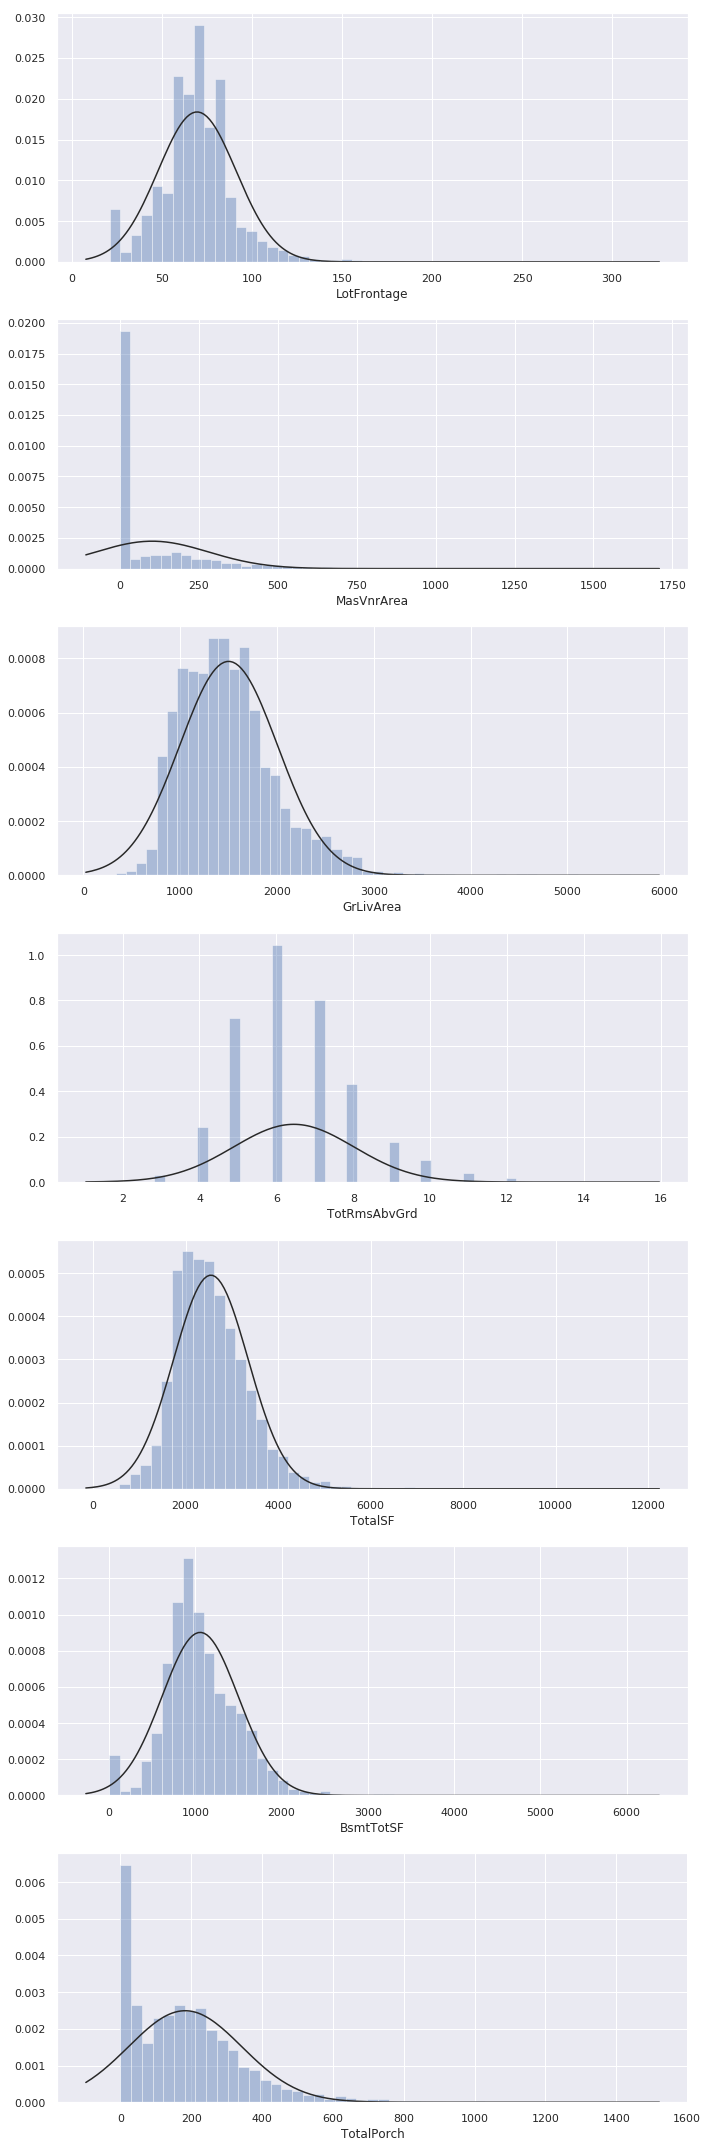

In [125]:
# Plot skew features before transforming.
i = 1
sns.set(rc={'figure.figsize':(10,30)})
for col in skew_list:
    plt.subplot(len(skew_list),1,i)
    sns.distplot(data[col], fit=stats.norm, kde=False, hist_kws={"label": col}, fit_kws={"label": "Normal Fit"})
    i = i + 1
plt.tight_layout()
# plt.savefig("skew_before.jpeg", dpi=150)

In [126]:
for col in skew_list:
    data[col] = boxcox1p(data[col], stats.boxcox_normmax(data[col] + 1))

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


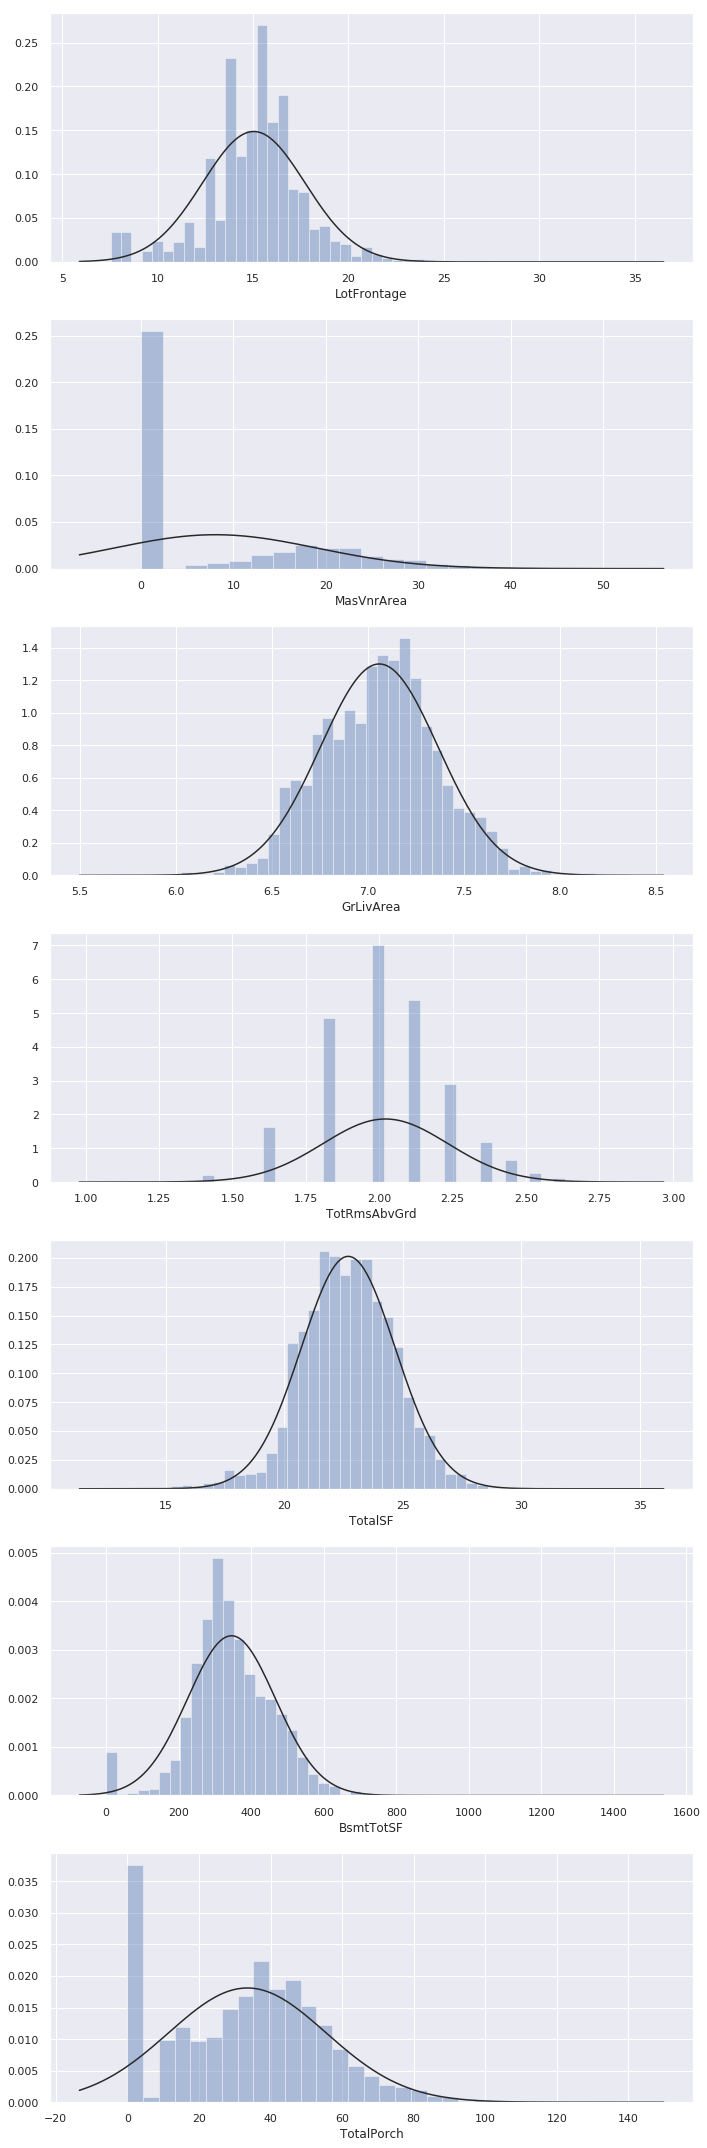

In [127]:
# Plot transformed features.
i = 1
sns.set(rc={'figure.figsize':(10,30)})
for col in skew_list:
    plt.subplot(len(skew_list),1,i)
    sns.distplot(data[col], fit=stats.norm, kde=False, hist_kws={"label": col}, fit_kws={"label": "Normal Fit"})
    i = i + 1
plt.tight_layout()
# plt.savefig("skew_after.jpeg", dpi=150)

----
# Outliers

Only the very extreme values are used to drop row entries. If more rows are dropped the test scores of the models decrease significantly.

In [128]:
def find_outliers(df):
    listd = []
    for col in df.columns:
        upper = df[col].mean() + 5*(df[col].std())
        lower = df[col].mean() - 5*(df[col].std())
        
        dropp = df[(df[col] > upper) | (df[col] < lower)][[col]].index.tolist()
        listd.append(dropp)
        print(col, dropp)
        #df.drop(dropp, axis=0, inplace=True)
    return list(set([item for sublist in listd for item in sublist]))

In [129]:
to_drop = find_outliers(data.loc[:1460, numerical])

LotFrontage [935, 1299]
LotArea [250, 314, 336, 452, 707, 1299]
OverallQual []
OverallCond []
YearBuilt []
YearRemodAdd []
MasVnrArea []
GrLivArea []
BedroomAbvGr [636]
TotRmsAbvGrd []
GarageYrBlt []
GarageCars []
TotalSF [534, 1299]
Baths []
BsmtTotSF [1299]
TotalPorch []


In [130]:
len(to_drop)/df_test.shape[0]*100

0.616860863605209

In [131]:
data.drop(to_drop, inplace=True)
target_log1p.drop(to_drop, inplace=True)

In [132]:
data.loc[:1460].shape

(1451, 67)

In [133]:
target_log1p.shape

(1451, 1)

----
# Encode Categorical Features

In [134]:
def encode_data(input_df, cols):
    
    input_df = pd.get_dummies(input_df, columns=cols, drop_first=True, prefix=cols, prefix_sep='_')
    
    return input_df

In [135]:
encoded_df = encode_data(data, data[categorical].columns.tolist())

# Datasets for different models

Two datasets are made: one for linear regression correlation filtering and one for the rest.

In [136]:
LData = encoded_df.loc[:1460]
RData = encoded_df[:]

# Multiple Linear Regression with Variable Selection

## Correlated Columns

In [137]:
LData['SalePrice'] = target_log1p['SalePrice'].values

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [138]:
linear_cols = LData.corr()[abs(LData.corr()['SalePrice']) > 0.5][['SalePrice']].sort_values(by='SalePrice', ascending=False).index.tolist()
LData.loc[:, linear_cols].corr() > 0.8

,SalePrice,OverallQual,TotalSF,GrLivArea,GarageCars,Baths,BsmtTotSF,YearBuilt,GarageYrBlt,YearRemodAdd,TotRmsAbvGrd,Foundation_PConc,ExterQual_Gd,FireP_Y,FireplaceQu_none,KitchenQual_TA,ExterQual_TA
SalePrice,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
OverallQual,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
TotalSF,True,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False
GrLivArea,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False
GarageCars,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
Baths,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
BsmtTotSF,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
YearBuilt,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False
GarageYrBlt,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False
YearRemodAdd,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [139]:
multi_coll = ['GrLivArea','GarageYrBlt','SalePrice']

In [140]:
use_cols = [col for col in linear_cols if col not in multi_coll]
use_cols.append('SalePrice')
LData.loc[:, use_cols].corr()['SalePrice']

OverallQual         0.819772
TotalSF             0.818433
GarageCars          0.682358
Baths               0.673477
BsmtTotSF           0.625601
YearBuilt           0.592338
YearRemodAdd        0.567787
TotRmsAbvGrd        0.539947
Foundation_PConc    0.539720
ExterQual_Gd        0.515438
FireP_Y             0.508479
FireplaceQu_none   -0.508479
KitchenQual_TA     -0.545231
ExterQual_TA       -0.608236
SalePrice           1.000000
Name: SalePrice, dtype: float64

In [141]:
use_cols.remove('SalePrice')

In [142]:
use_cols

['OverallQual',
 'TotalSF',
 'GarageCars',
 'Baths',
 'BsmtTotSF',
 'YearBuilt',
 'YearRemodAdd',
 'TotRmsAbvGrd',
 'Foundation_PConc',
 'ExterQual_Gd',
 'FireP_Y',
 'FireplaceQu_none',
 'KitchenQual_TA',
 'ExterQual_TA']

In [143]:
RData.isna().sum().sum()

0

## Evaluation Functions

The function below is used to plot the performance of a model.

In [144]:
# Function called after a models has been trained and predicted values.
# This plots visuals to assess the model's performance.
def evaluate_models(model_label):
    plt.figure(figsize=(15,10))
    plt.subplot(2,3,1)
    plt.scatter(range(len(y_train)), y_train.sort_values(by='SalePrice'), label='Actual Train SalePrice Ordered')
    plt.scatter(range(len(y_pred_train)), sorted(y_pred_train), label='Predicted Train SalePrice Ordered')
    plt.legend()
    plt.xlabel('Observation')
    plt.ylabel('SalePrice')
    
    plt.subplot(2,3,2)
    errors = np.array(y_pred_train.reshape(-1,1) - y_train)
    errors = np.round(errors, 2)
    plt.hist(errors, label='Train Errors')
    plt.legend()
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    
    plt.subplot(2,3,3)
    plt.scatter(y_train, y_pred_train.reshape(-1,1), label='y_train vs y_train_predicted')
    plt.legend()
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    
    plt.subplot(2,3,4)
    plt.scatter(range(len(y_test)), y_test.sort_values(by='SalePrice'), label='Actual Test SalePrice Ordered')
    plt.scatter(range(len(y_pred_test)), sorted(y_pred_test), label='Predicted Test SalePrice Ordered')
    plt.legend()
    plt.xlabel('Observation')
    plt.ylabel('SalePrice')
    
    plt.subplot(2,3,5)
    errors = np.array(y_pred_test.reshape(-1,1) - y_test)
    errors = np.round(errors, 2)
    plt.hist(errors, label='Test Errors')
    plt.legend()
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    
    plt.subplot(2,3,6)
    plt.scatter(y_test, y_pred_test.reshape(-1,1), label='y_test vs y_test_predicted')
    plt.legend()
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    
    plt.tight_layout()
#     plt.savefig(model_label+".jpeg", dpi=150)
    plt.show()

In [145]:
# Function to calculate the MSE, R2 and LMSE metrics for y_actual and y_predicted.
def get_score(y_actual, y_predicted, label=''):
    MSE       = metrics.mean_squared_error(y_actual, y_predicted)
    R_squared = metrics.r2_score(y_actual, y_predicted)
    LMSE      = np.sqrt(MSE)
    
    print('-------'+label+'--------')
    print('MSE_'+label+':', MSE)
    print('R_squared_'+label+':', R_squared)
    print('LMSE_'+label+':', LMSE)

----
## Choose X, X_sub and y for Linear Model

In [146]:
y = target_log1p
X = RData.loc[:1460,use_cols]
X_sub = RData.loc[1461:,use_cols]

## Linear Model

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

-------Train--------
MSE_Train: 0.022782603361179755
R_squared_Train: 0.8551995589529718
LMSE_Train: 0.15093907168516624
-------Test--------
MSE_Test: 0.02202068557742371
R_squared_Test: 0.8616953905545923
LMSE_Test: 0.14839368442566453


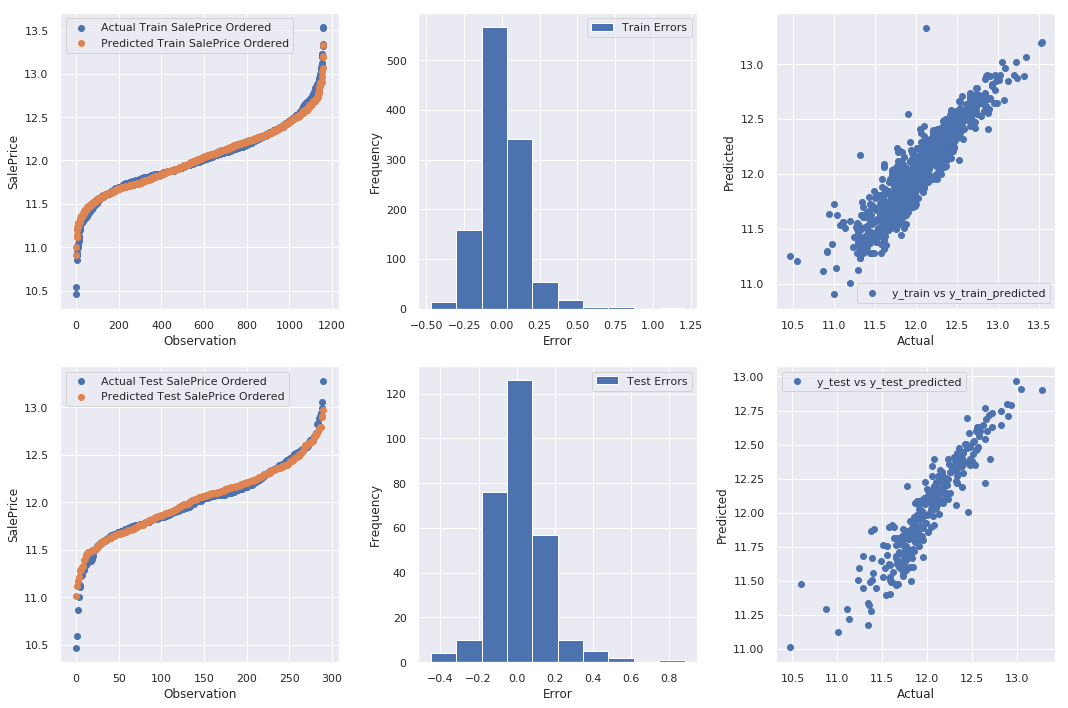

In [148]:
lm1 = LinearRegression()
lm1.fit(X_train, y_train)

y_pred_train = lm1.predict(X_train)
get_score(y_train, y_pred_train, 'Train')

y_pred_test = lm1.predict(X_test)
get_score(y_test, y_pred_test, 'Test')

evaluate_models('Linear')

----
# Choose X, X_sub and y for Remaining Models

In [149]:
y = target_log1p
X = RData.loc[:1460]
X_sub = encoded_df.loc[1461:]

# Decision Tree and Random Forest

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
-------Train--------
MSE_Train: 6.576376465820285e-10
R_squared_Train: 0.9999999958202221
LMSE_Train: 2.5644446700641223e-05
-------Test--------
MSE_Test: 0.03700714496360275
R_squared_Test: 0.7675704186009512
LMSE_Test: 0.19237241216869624


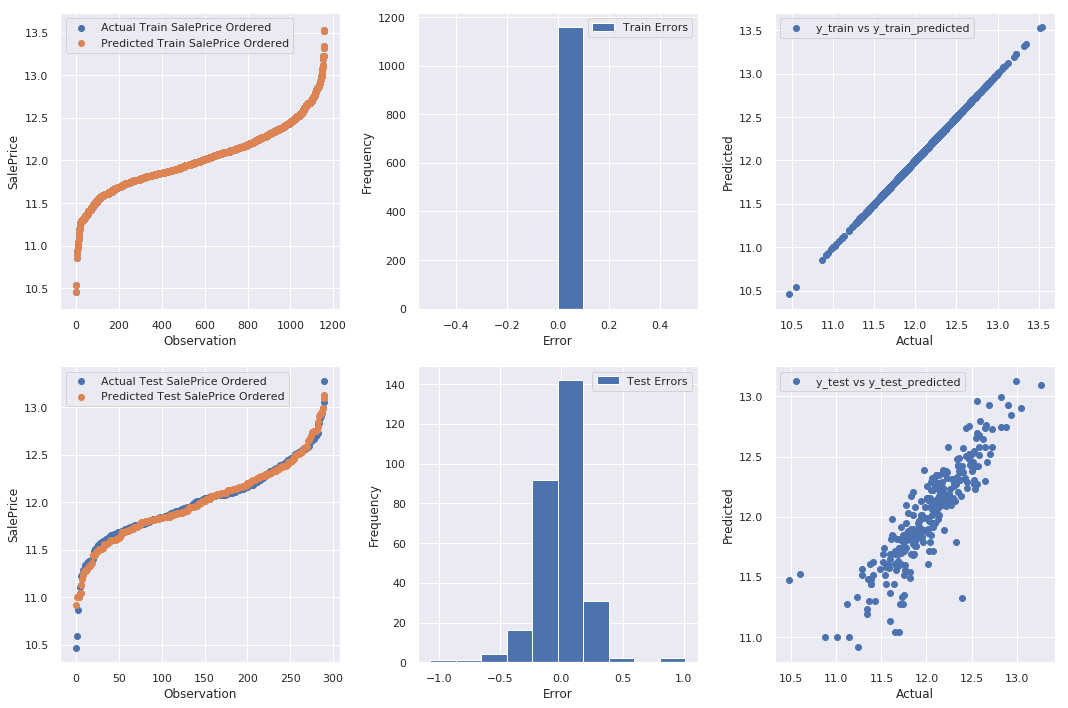


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
-------Train--------
MSE_Train: 0.0029253052397498077
R_squared_Train: 0.9814075028126628
LMSE_Train: 0.05408609100082763
-------Test--------
MSE_Test: 0.019065218018511028
R_squared_Test: 0.8802577002986204
LMSE_Test: 0.13807685547734286


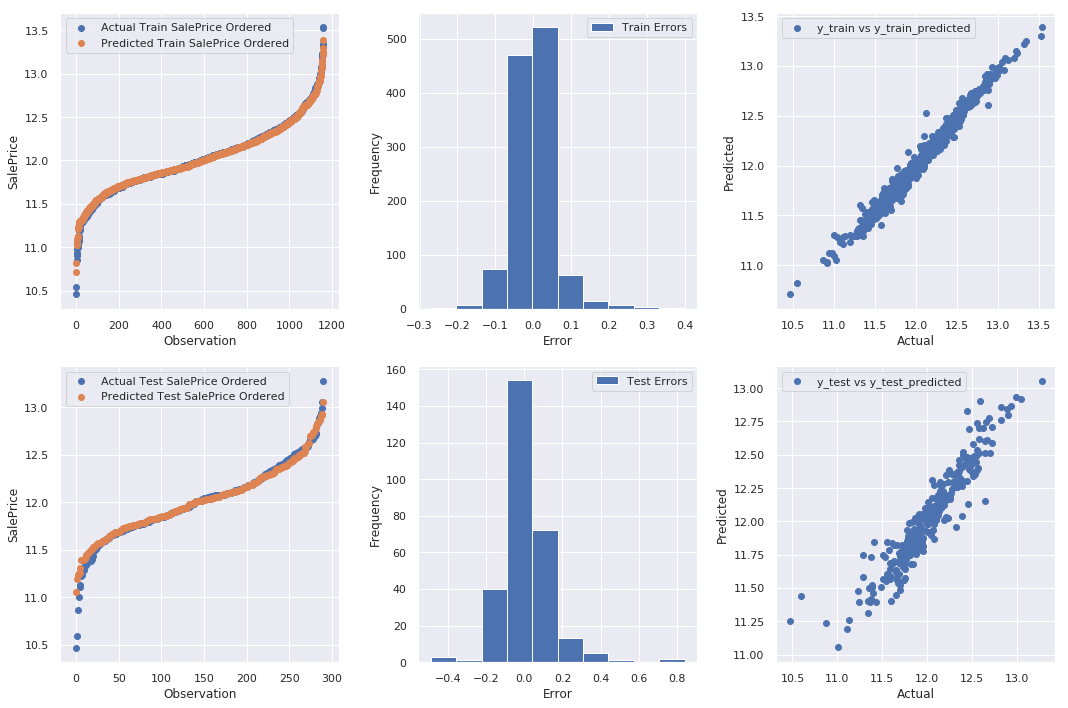

In [151]:
DTreg = DecisionTreeRegressor()
RFreg = RandomForestRegressor(n_estimators=100)

DTreg.fit(X_train, y_train)
RFreg.fit(X_train, y_train.values.ravel())

models = [DTreg, RFreg]
modelstr = ['Decision', 'RandomForest']

i = 0
for modl in models:
    print(modl)
    y_pred_train = modl.predict(X_train)
    get_score(y_train, y_pred_train, 'Train')
    
    y_pred_test = modl.predict(X_test)
    get_score(y_test, y_pred_test, 'Test')
    
    evaluate_models(modelstr[i])
    i = i + 1

    print()

----
# Regularized Models

The data is scaled to ensure the regularization penalties are applied fairly across all features and is not affected by a features range. The z standardization ensures a large enough range.

In [152]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_sub_scaled = scaler.fit_transform(X_sub)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [153]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)


----
## Modelling

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
-------Train--------
MSE_Train: 0.008370384910829937
R_squared_Train: 0.9467999592668674
LMSE_Train: 0.09148980768823343
-------Test--------
MSE_Test: 0.019650009718767927
R_squared_Test: 0.8765848179341464
LMSE_Test: 0.14017849235445473


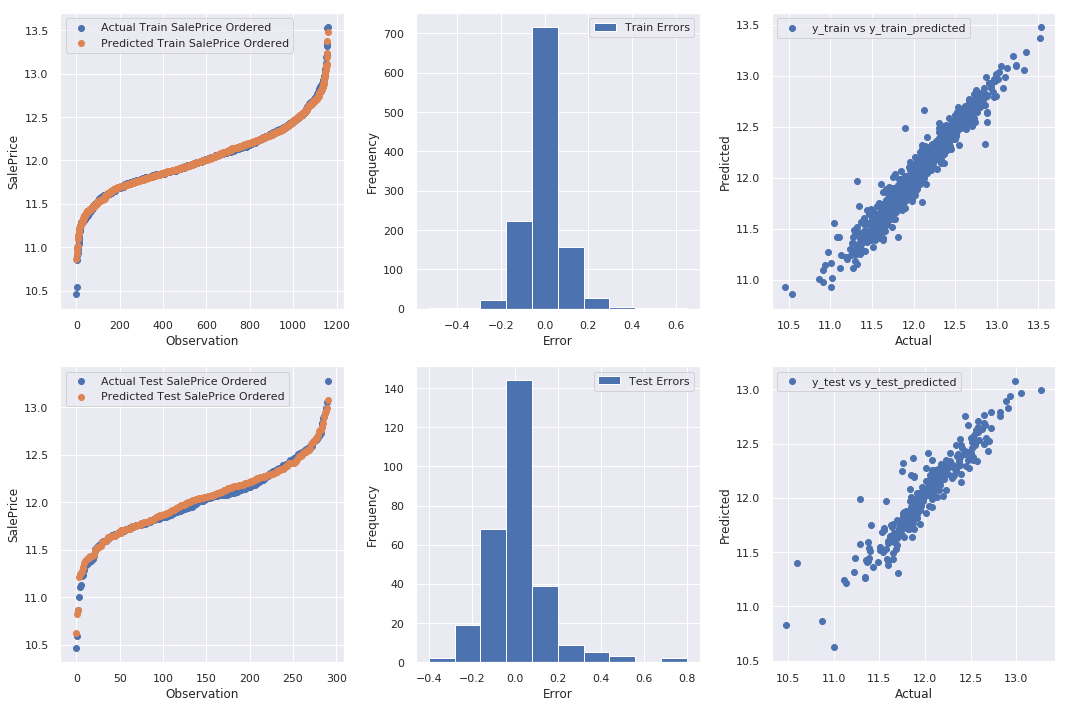


Lasso(alpha=0.003, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
-------Train--------
MSE_Train: 0.010565431041077525
R_squared_Train: 0.9328488035214266
LMSE_Train: 0.10278828260593484
-------Test--------
MSE_Test: 0.013801775710957892
R_squared_Test: 0.9133156325834761
LMSE_Test: 0.11748095892934264


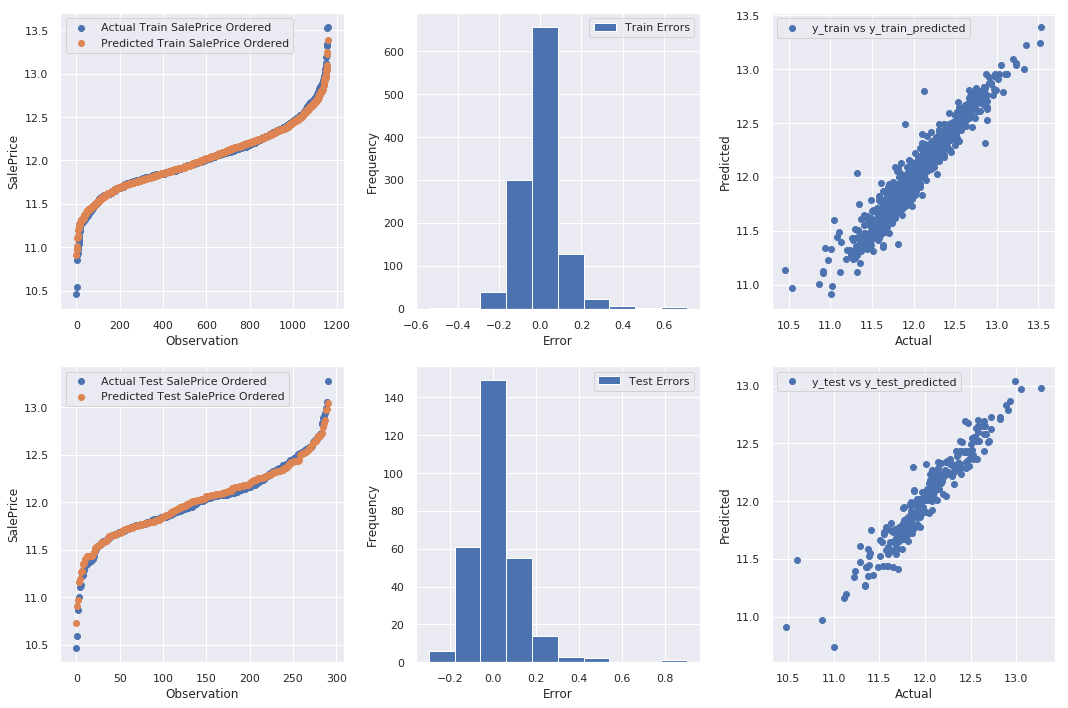

In [154]:
ridge = Ridge(alpha=10)
lasso = Lasso(alpha=0.003)

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

models = [ridge, lasso ]
modelstr = ['ridge', 'lasso']

i = 0
for modl in models:
    print(modl)
    y_pred_train = modl.predict(X_train)
    get_score(y_train, y_pred_train, 'Train')
    
    y_pred_test = modl.predict(X_test)
    get_score(y_test, y_pred_test, 'Test')
    
    evaluate_models(modelstr[i])
    i = i + 1

    print()

In [155]:
coeff = pd.DataFrame(lasso.coef_, X.columns, columns=['Coefficient'])

In [156]:
coeff.sort_values(by='Coefficient', ascending=False)[:10]

,Coefficient
TotalSF,0.093634
OverallQual,0.075056
GrLivArea,0.060445
YearBuilt,0.057217
OverallCond,0.043222
GarageCars,0.037030
Neighborhood_Crawfor,0.022826
Baths,0.022284
Neighborhood_NridgHt,0.020562
LotArea,0.019739


In [157]:
coeff.sort_values(by='Coefficient', ascending=True)[:10]

,Coefficient
Condition2_PosN,-0.022020
BsmtFinType1_Unf,-0.020719
KitchenQual_Gd,-0.015371
KitchenQual_TA,-0.014704
Heating_Grav,-0.012629
FireplaceQu_none,-0.009743
BsmtQual_TA,-0.009742
MSSubClass_MSC90,-0.008949
Functional_Maj2,-0.008706
MSSubClass_MSC160,-0.008634


In [158]:
lasso.intercept_

array([12.02490152])

----
# Submission

In [159]:
# Use the sample submission file for the correct format and index.
sub = sample_sub

In [160]:
# Replace the data with the lasso model (best performance) predictions
sub['SalePrice'] = np.exp(lasso.predict(X_sub_scaled))-1

In [161]:
# save the submission
sub.to_csv('submission.csv')